In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import from src module (if needed for schemas/utilities)
from src import JobEnrichment, ExtractionQuality

sns.set_style("whitegrid")

# Load results
results_df = pd.read_pickle("data/extraction_experiment_results.pkl")

# Filter for successful extractions only
results_df = results_df[results_df['extraction_success'] == True].copy()

In [2]:
# Check results_df structure
print(f"Results DataFrame shape: {results_df.shape}")
results_df.head()

Results DataFrame shape: (685, 24)


,job_id,job_title,job_company,job_description,description_length,description_language,extraction_model,prompt_version,extraction_time,input_tokens,...,completeness_score,accuracy_score,specificity_score,hallucination_score,missing_critical_info,generic_extractions,fabricated_info,timestamp,error,judge_error
0,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:1.7b-q4_K_M,direct,3.064542,1261.0,...,8.0,9.0,8.0,9.0,"[Salary range ($176,166.00 - $251,666.00 plus ...",[Flexible work arrangements - this is vague; t...,[],2025-11-15 17:37:18.201762,NaN,NaN
1,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:1.7b-q4_K_M,direct,3.064542,1261.0,...,8.0,9.0,9.0,9.0,[Location-based requirement: the role is withi...,[Remote details: 'Flexible work arrangements' ...,[],2025-11-15 17:37:22.010669,NaN,NaN
2,1,Data Engineer,Accenture,Accenture Flex offers you the flexibility of l...,6312,English,qwen3:1.7b-q4_K_M,direct,3.771740,1380.0,...,7.0,8.0,7.0,9.0,[Job title/role name ('Data Engineer' for Acce...,[Key responsibilities are somewhat condensed a...,[The preferred_skills field duplicates what's ...,2025-11-15 17:37:37.003256,NaN,NaN
3,1,Data Engineer,Accenture,Accenture Flex offers you the flexibility of l...,6312,English,qwen3:1.7b-q4_K_M,direct,3.771740,1380.0,...,8.0,9.0,8.0,10.0,"[High School Diploma or GED requirement, Menti...","[Remote details 'Remote, Bay Area Preferred' c...",[],2025-11-15 17:37:41.057893,NaN,NaN
4,2,Data Scientist,Audible,"At Audible, we believe stories have the power ...",5260,English,qwen3:1.7b-q4_K_M,direct,3.700372,1139.0,...,8.0,7.0,7.0,8.0,[SQL and Python specifically mentioned as requ...,[required_skills lists degree fields rather th...,[seniority_level: 'Mid/Senior' - the job requi...,2025-11-15 17:37:52.036455,NaN,NaN


# Viz

In [3]:
models = results_df['extraction_model'].unique().tolist()

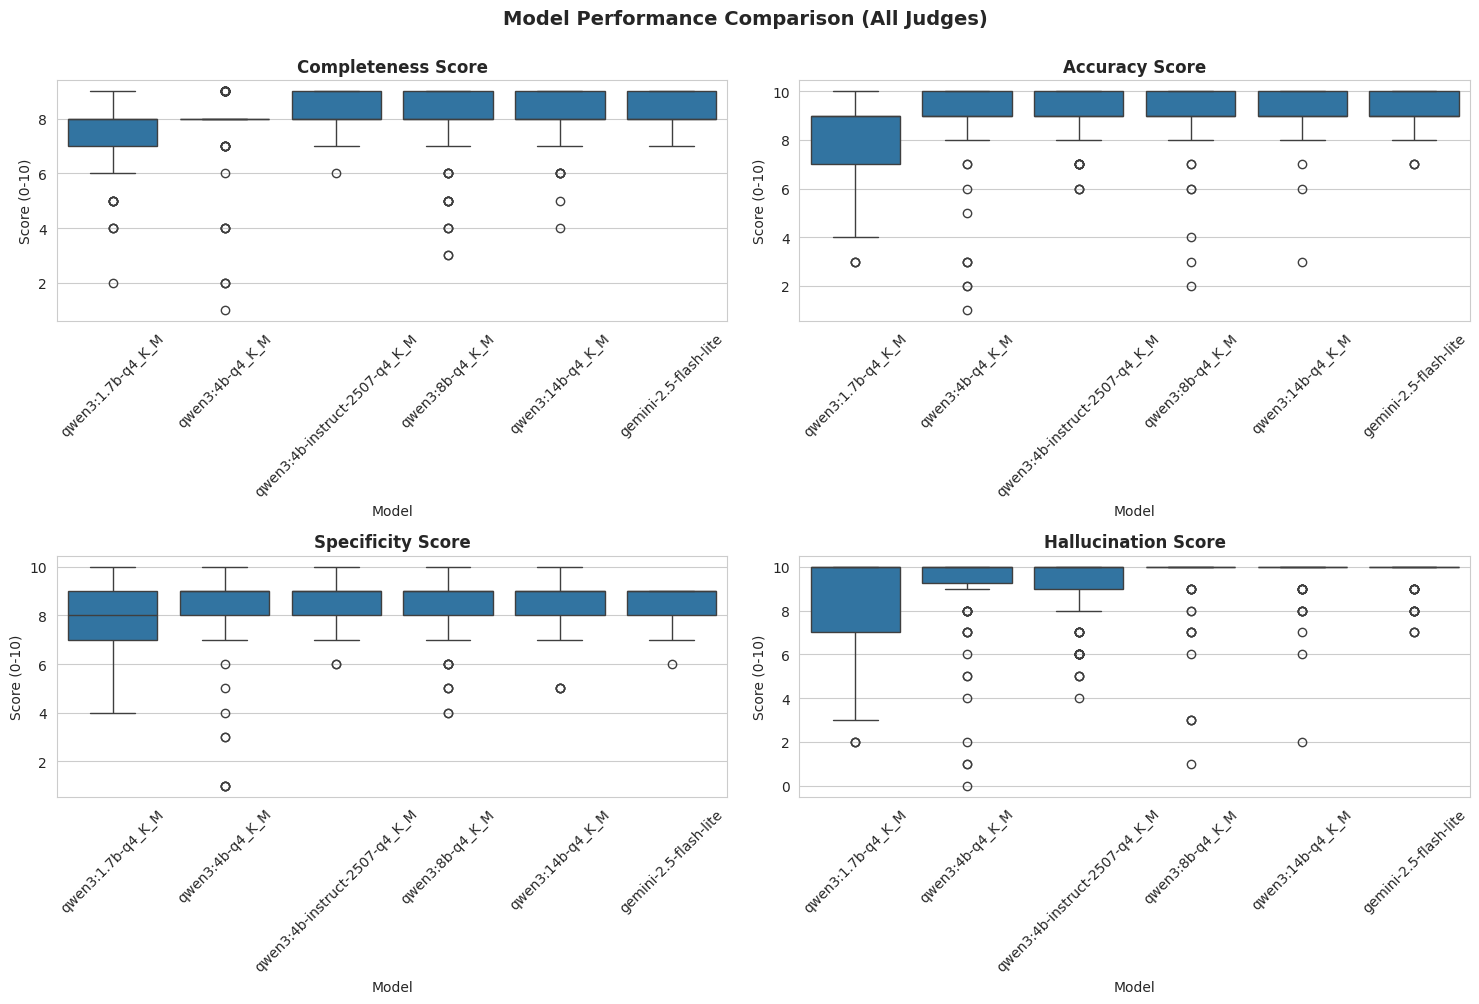

✓ Saved: figs/model_comparison.png


In [22]:
plt.rcParams['figure.figsize'] = (15, 10)

# ensure extraction_model follows the desired order
results_df['extraction_model'] = pd.Categorical(
    results_df['extraction_model'],
    categories=models,
    ordered=True
)

metrics = ["completeness_score", "accuracy_score", "specificity_score", "hallucination_score"]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, metric in zip(axes.flat, metrics):
    if metric in results_df.columns:
        # use seaborn boxplot with explicit order (or pandas will respect the categorical dtype)
        sns.boxplot(x="extraction_model", y=metric, data=results_df, order=models, ax=ax)
        ax.set_title(metric.replace("_", " ").title(), fontsize=12, fontweight='bold')
        ax.set_xlabel("Model", fontsize=10)
        ax.set_ylabel("Score (0-10)", fontsize=10)
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.text(0.5, 0.5, f"No data for {metric}", ha='center', va='center')

plt.suptitle("Model Performance Comparison (All Judges)", y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("figs/model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figs/model_comparison.png")

/tmp/ipykernel_1173433/1826552709.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = results_df.pivot_table(
/tmp/ipykernel_1173433/1826552709.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = results_df.pivot_table(
/tmp/ipykernel_1173433/1826552709.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = results_df.pivot_table(
/tmp/ipykernel_1173433/1826552709.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future vers

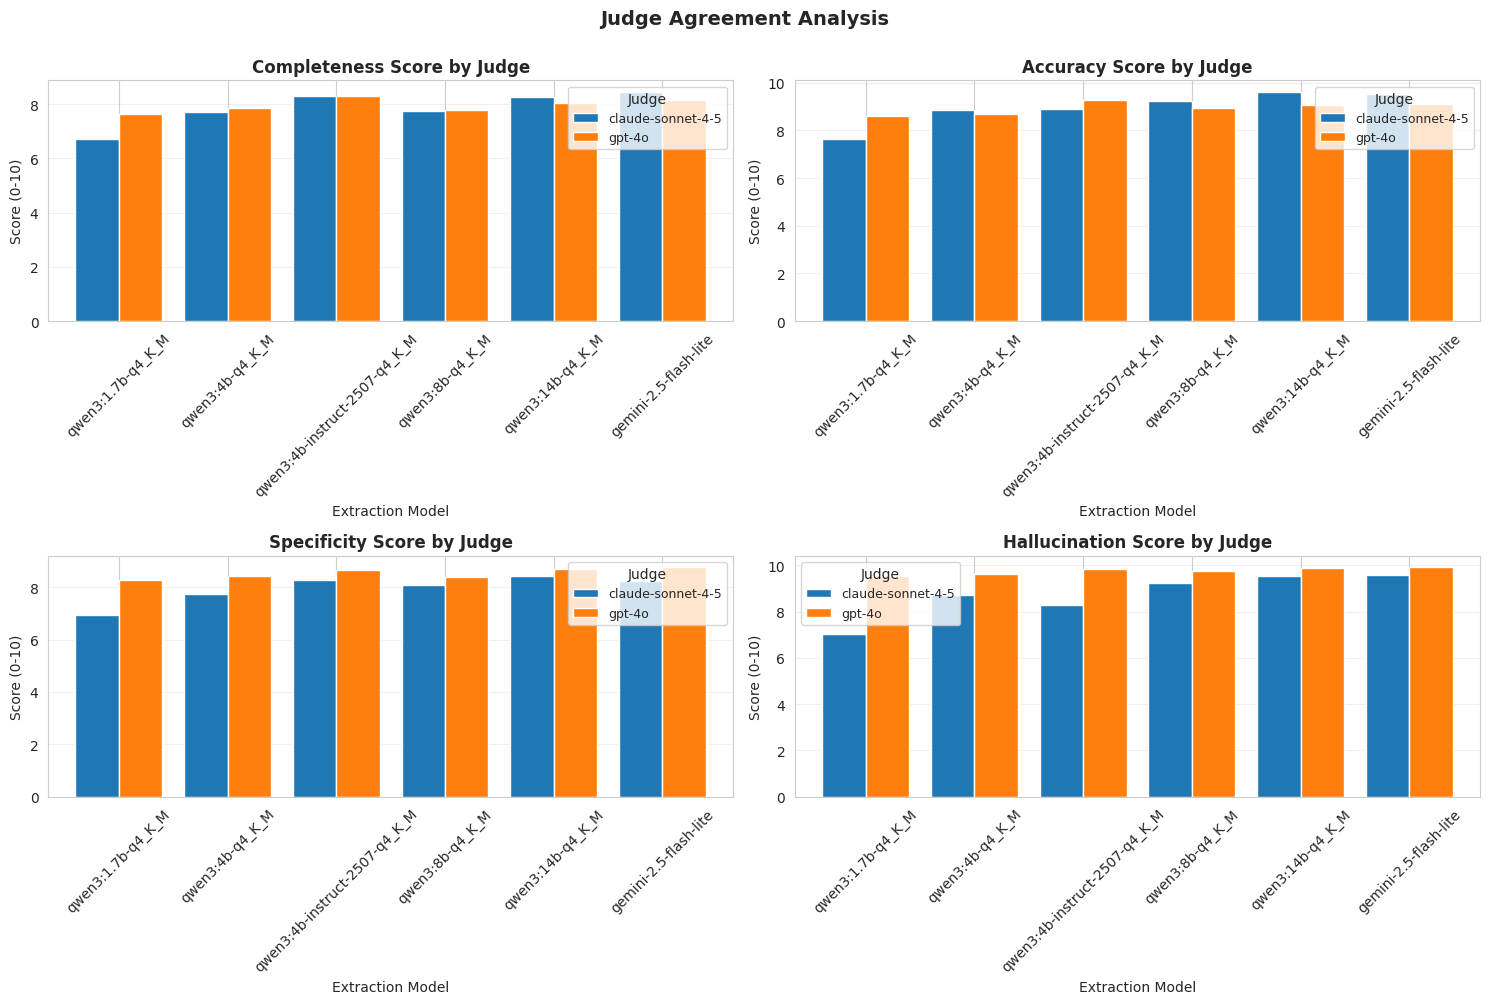

✓ Saved: figs/judge_agreement.png


In [23]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, metric in zip(axes.flat, metrics):
    if metric in results_df.columns:
        # Create pivot table: models vs judges
        pivot = results_df.pivot_table(
            values=metric,
            index="extraction_model",
            columns="judge_model",
            aggfunc="mean"
        )
        if not pivot.empty:
            pivot.plot(kind='bar', ax=ax, width=0.8)
            ax.set_title(f"{metric.replace('_', ' ').title()} by Judge", fontsize=12, fontweight='bold')
            ax.set_xlabel("Extraction Model", fontsize=10)
            ax.set_ylabel("Score (0-10)", fontsize=10)
            ax.legend(title="Judge", fontsize=9)
            ax.grid(axis='y', alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        else:
            ax.text(0.5, 0.5, f"No data for {metric}", ha='center', va='center')
plt.suptitle("Judge Agreement Analysis", y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("figs/judge_agreement.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figs/judge_agreement.png")

/tmp/ipykernel_1173433/3297576453.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_data = results_df.groupby("extraction_model")["extraction_time"].agg(["mean", "std"]).sort_values("mean")


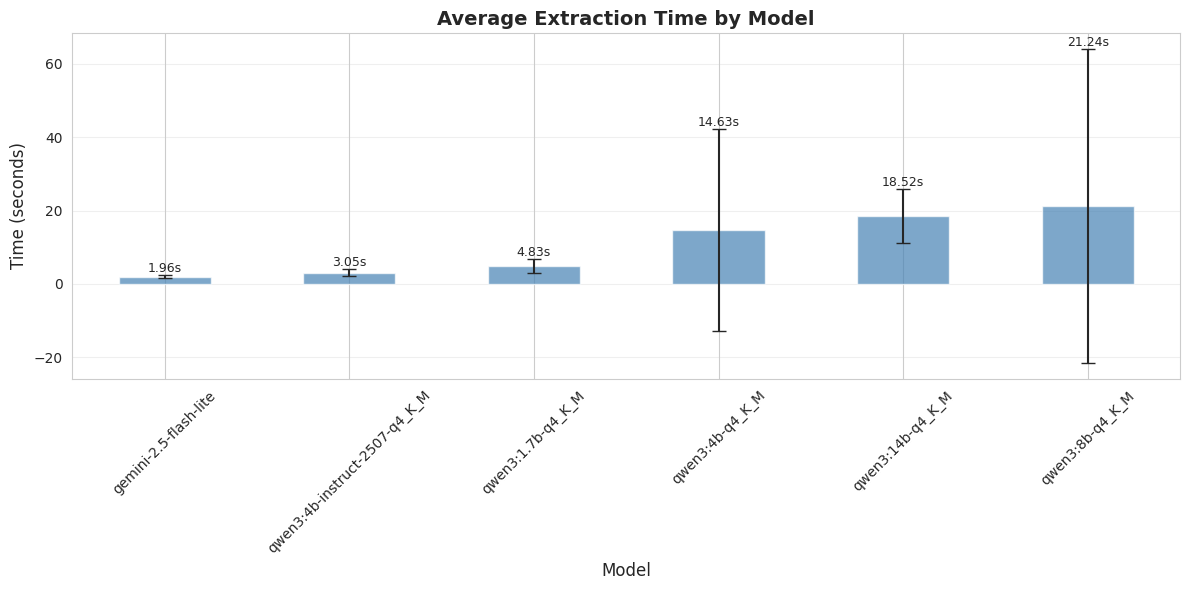

✓ Saved: figs/extraction_time_comparison.png


In [24]:

fig, ax = plt.subplots(figsize=(12, 6))

# Get average extraction time per model
time_data = results_df.groupby("extraction_model")["extraction_time"].agg(["mean", "std"]).sort_values("mean")

if not time_data.empty:
    # Create bar plot with error bars
    time_data["mean"].plot(kind='bar', ax=ax, yerr=time_data["std"], capsize=5, color='steelblue', alpha=0.7)
    ax.set_title("Average Extraction Time by Model", fontsize=14, fontweight='bold')
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Time (seconds)", fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (idx, row) in enumerate(time_data.iterrows()):
        ax.text(i, row["mean"] + row["std"] + 0.05, f'{row["mean"]:.2f}s',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig("figs/extraction_time_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Saved: figs/extraction_time_comparison.png")
else:
    print("⚠ No extraction time data available!")

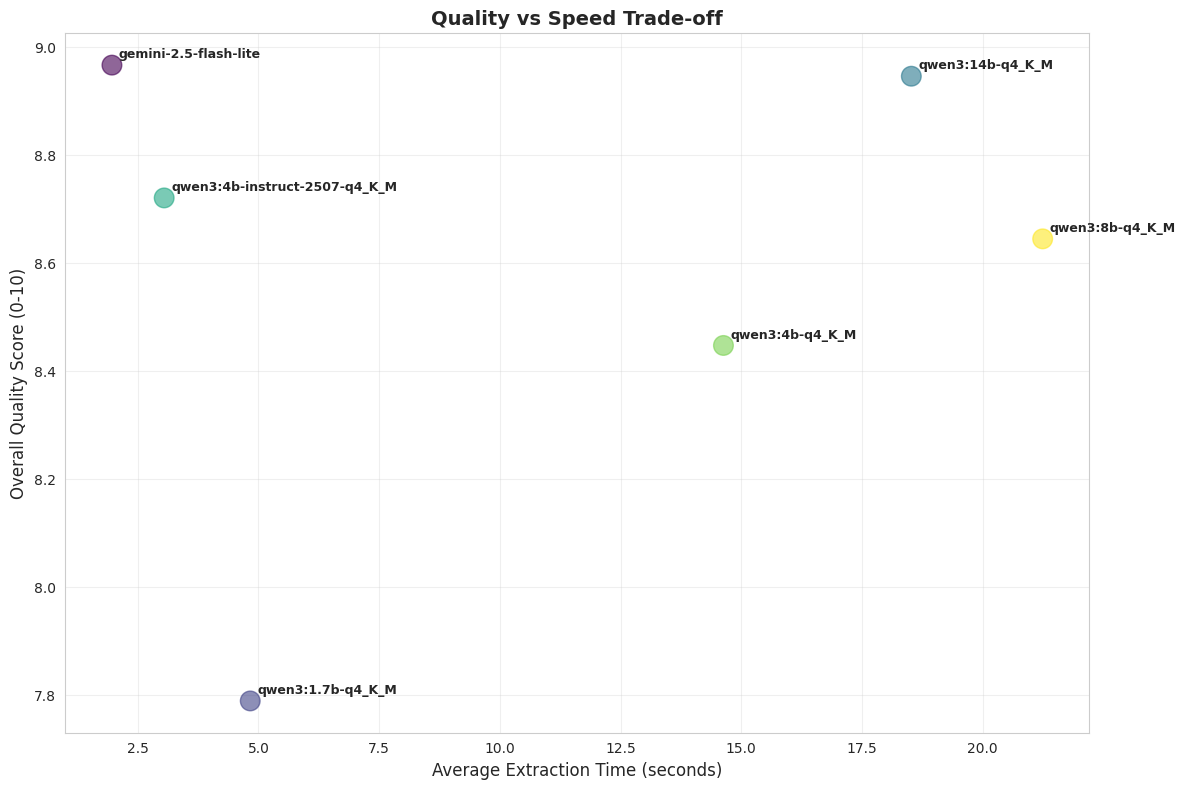

✓ Saved: figs/quality_vs_speed.png

=== QUALITY vs SPEED ===
                               extraction_time  overall_quality
extraction_model                                               
gemini-2.5-flash-lite                 1.964925         8.966667
qwen3:14b-q4_K_M                     18.523423         8.946121
qwen3:4b-instruct-2507-q4_K_M         3.047051         8.720833
qwen3:8b-q4_K_M                      21.243808         8.645089
qwen3:4b-q4_K_M                      14.631689         8.447727
qwen3:1.7b-q4_K_M                     4.829638         7.789720


In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
# Calculate average scores and times per model
model_summary = results_df.groupby("extraction_model").agg({
    "completeness_score": "mean",
    "accuracy_score": "mean",
    "specificity_score": "mean",
    "hallucination_score": "mean",
    "extraction_time": "mean"
})
if not model_summary.empty:
    # Calculate overall quality score (average of all metrics)
    model_summary["overall_quality"] = model_summary[
        ["completeness_score", "accuracy_score", "specificity_score", "hallucination_score"]
    ].mean(axis=1)
    # Create scatter plot
    scatter = ax.scatter(
        model_summary["extraction_time"],
        model_summary["overall_quality"],
        s=200,
        alpha=0.6,
        c=range(len(model_summary)),
        cmap='viridis'
    )
    # Add labels for each point
    for idx, row in model_summary.iterrows():
        ax.annotate(
            idx,
            (row["extraction_time"], row["overall_quality"]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            fontweight='bold'
        )
    ax.set_title("Quality vs Speed Trade-off", fontsize=14, fontweight='bold')
    ax.set_xlabel("Average Extraction Time (seconds)", fontsize=12)
    ax.set_ylabel("Overall Quality Score (0-10)", fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("figs/quality_vs_speed.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: figs/quality_vs_speed.png")
    print("\n=== QUALITY vs SPEED ===")
    print(model_summary[["extraction_time", "overall_quality"]].sort_values("overall_quality", ascending=False))
else:
    print("⚠ No quality/speed data available!")

/tmp/ipykernel_1173433/2026604380.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_data = results_df.groupby("size_category")[metric].agg(["mean", "std"])
/tmp/ipykernel_1173433/2026604380.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_data = results_df.groupby("size_category")[metric].agg(["mean", "std"])
/tmp/ipykernel_1173433/2026604380.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_data

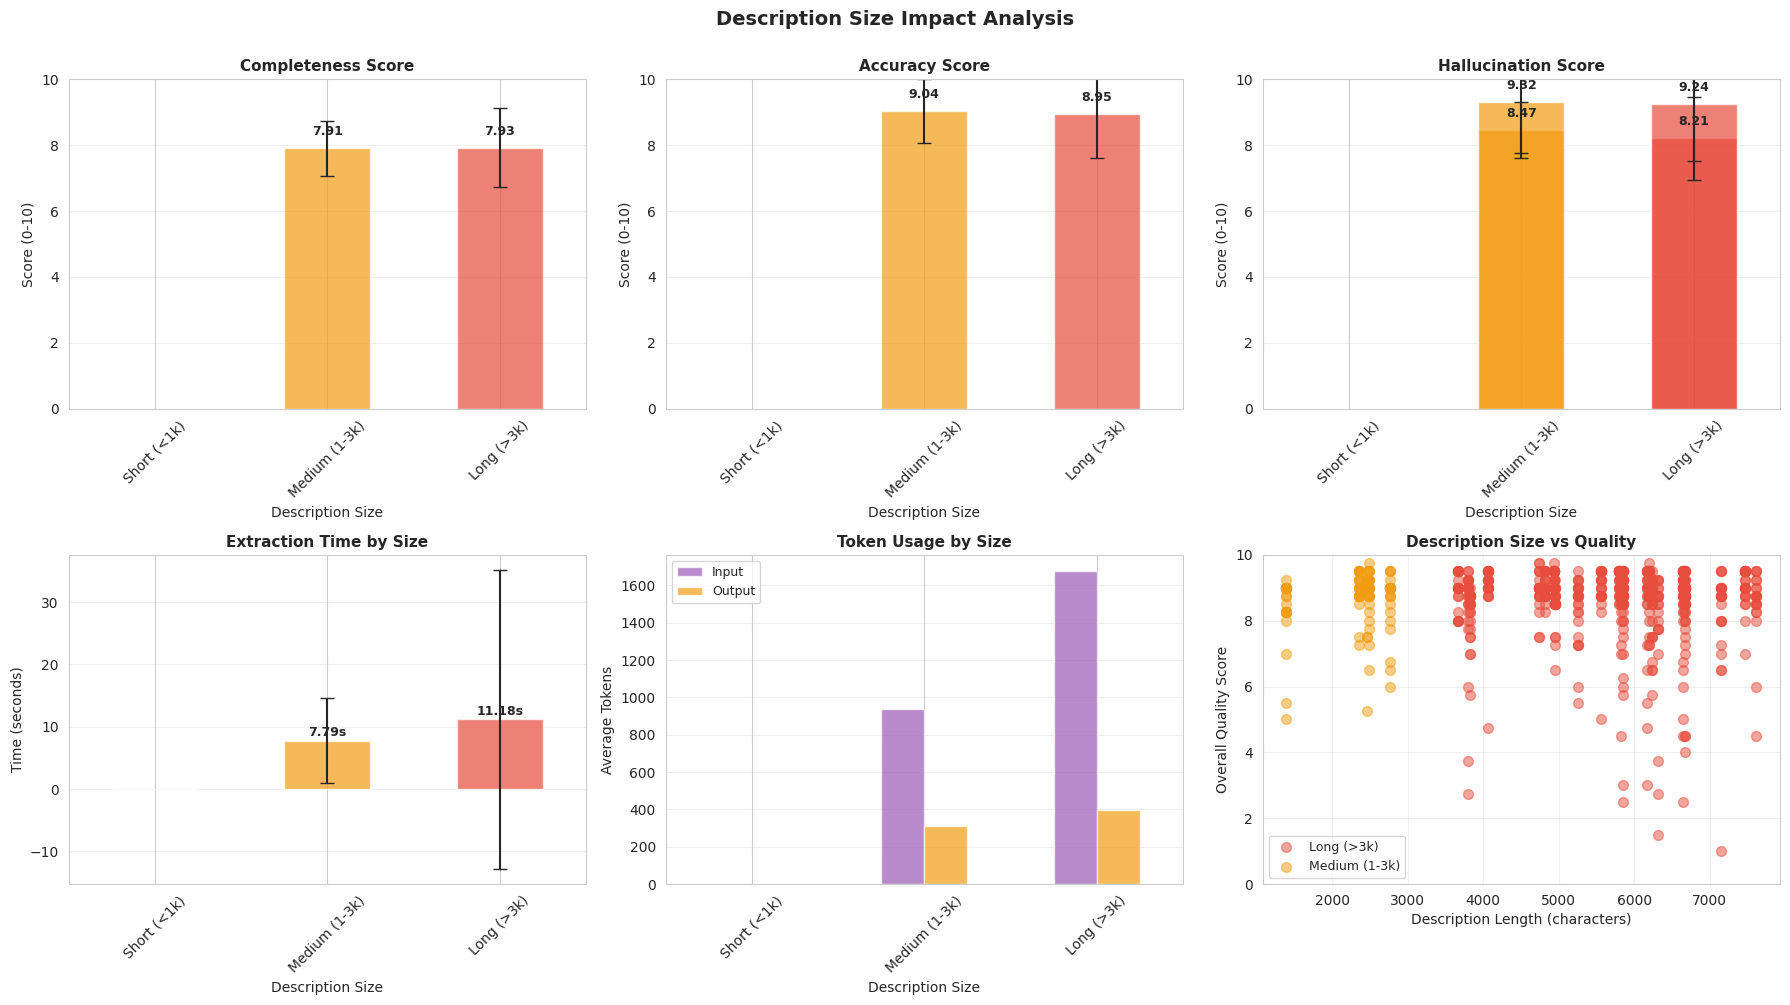

✓ Saved: figs/size_analysis.png

=== SIZE CATEGORY STATISTICS ===
              completeness_score       accuracy_score       specificity_score  \
                            mean   std           mean   std              mean   
size_category                                                                   
Short (<1k)                  NaN   NaN            NaN   NaN               NaN   
Medium (1-3k)               7.91  0.84           9.04  0.98              8.47   
Long (>3k)                  7.93  1.21           8.95  1.35              8.21   

                    hallucination_score       extraction_time         \
                std                mean   std            mean    std   
size_category                                                          
Short (<1k)     NaN                 NaN   NaN             NaN    NaN   
Medium (1-3k)  0.85                9.32  1.56            7.79   6.87   
Long (>3k)     1.27                9.24  1.73           11.18  24.01   

              

/tmp/ipykernel_1173433/2026604380.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_stats = results_df.groupby("size_category")[metrics + ["extraction_time", "description_length"]].agg(["mean", "std"]).round(2)
/tmp/ipykernel_1173433/2026604380.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(results_df.groupby("size_category")["job_id"].nunique())


In [26]:

# Create size categories
results_df["size_category"] = pd.cut(
    results_df["description_length"],
    bins=[0, 1000, 3000, float('inf')],
    labels=["Short (<1k)", "Medium (1-3k)", "Long (>3k)"]
)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# Quality metrics by size
for ax, metric in zip(axes[0], metrics[:3]):
    if metric in results_df.columns:
        size_data = results_df.groupby("size_category")[metric].agg(["mean", "std"])
        if not size_data.empty:
            colors = ['#2ecc71', '#f39c12', '#e74c3c']
            size_data["mean"].plot(kind='bar', ax=ax, yerr=size_data["std"],
                                  capsize=5, color=colors, alpha=0.7)
            ax.set_title(f"{metric.replace('_', ' ').title()}", fontsize=11, fontweight='bold')
            ax.set_xlabel("Description Size", fontsize=10)
            ax.set_ylabel("Score (0-10)", fontsize=10)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(axis='y', alpha=0.3)
            ax.set_ylim(0, 10)
            # Add value labels
            for i, (idx, row) in enumerate(size_data.iterrows()):
                ax.text(i, row["mean"] + 0.3, f'{row["mean"]:.2f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
# Hallucination score by size
ax = axes[0, 2]
if "hallucination_score" in results_df.columns:
    size_data = results_df.groupby("size_category")["hallucination_score"].agg(["mean", "std"])
    if not size_data.empty:
        colors = ['#2ecc71', '#f39c12', '#e74c3c']
        size_data["mean"].plot(kind='bar', ax=ax, yerr=size_data["std"],
                              capsize=5, color=colors, alpha=0.7)
        ax.set_title("Hallucination Score", fontsize=11, fontweight='bold')
        ax.set_xlabel("Description Size", fontsize=10)
        ax.set_ylabel("Score (0-10)", fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)
        for i, (idx, row) in enumerate(size_data.iterrows()):
            ax.text(i, row["mean"] + 0.3, f'{row["mean"]:.2f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
# Extraction time by size
ax = axes[1, 0]
if "extraction_time" in results_df.columns:
    time_data = results_df.groupby("size_category")["extraction_time"].agg(["mean", "std"])
    if not time_data.empty:
        colors = ['#2ecc71', '#f39c12', '#e74c3c']
        time_data["mean"].plot(kind='bar', ax=ax, yerr=time_data["std"],
                              capsize=5, color=colors, alpha=0.7)
        ax.set_title("Extraction Time by Size", fontsize=11, fontweight='bold')
        ax.set_xlabel("Description Size", fontsize=10)
        ax.set_ylabel("Time (seconds)", fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
        for i, (idx, row) in enumerate(time_data.iterrows()):
            ax.text(i, row["mean"] + 0.2, f'{row["mean"]:.2f}s',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
# Token usage by size
ax = axes[1, 1]
if "input_tokens" in results_df.columns and "output_tokens" in results_df.columns:
    token_data = results_df.groupby("size_category")[["input_tokens", "output_tokens"]].mean()
    if not token_data.empty:
        token_data.plot(kind='bar', ax=ax, color=['#9b59b6', '#f39c12'], alpha=0.7)
        ax.set_title("Token Usage by Size", fontsize=11, fontweight='bold')
        ax.set_xlabel("Description Size", fontsize=10)
        ax.set_ylabel("Average Tokens", fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(["Input", "Output"], fontsize=9)
        ax.grid(axis='y', alpha=0.3)
# Size vs Quality scatter
ax = axes[1, 2]
if all(m in results_df.columns for m in metrics):
    results_df["overall_quality"] = results_df[metrics].mean(axis=1)
    # Scatter plot with size color-coded
    colors_map = {"Short (<1k)": '#2ecc71', "Medium (1-3k)": '#f39c12', "Long (>3k)": '#e74c3c'}
    for size_cat in results_df["size_category"].unique():
        data = results_df[results_df["size_category"] == size_cat]
        ax.scatter(data["description_length"], data["overall_quality"],
                  alpha=0.5, s=50, label=size_cat, color=colors_map.get(size_cat, '#3498db'))
    ax.set_title("Description Size vs Quality", fontsize=11, fontweight='bold')
    ax.set_xlabel("Description Length (characters)", fontsize=10)
    ax.set_ylabel("Overall Quality Score", fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 10)
plt.suptitle("Description Size Impact Analysis", y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("figs/size_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figs/size_analysis.png")
# Statistical summary
print("\n=== SIZE CATEGORY STATISTICS ===")
size_stats = results_df.groupby("size_category")[metrics + ["extraction_time", "description_length"]].agg(["mean", "std"]).round(2)
print(size_stats)
print("\n=== JOB COUNTS BY SIZE ===")
print(results_df.groupby("size_category")["job_id"].nunique())
print("\n=== SIZE DISTRIBUTION ===")
print(f"Min length: {results_df['description_length'].min()}")
print(f"Max length: {results_df['description_length'].max()}")
print(f"Mean length: {results_df['description_length'].mean():.0f}")
print(f"Median length: {results_df['description_length'].median():.0f}")

/tmp/ipykernel_1173433/3345536316.py:41: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  lang_model_perf = results_df.pivot_table(


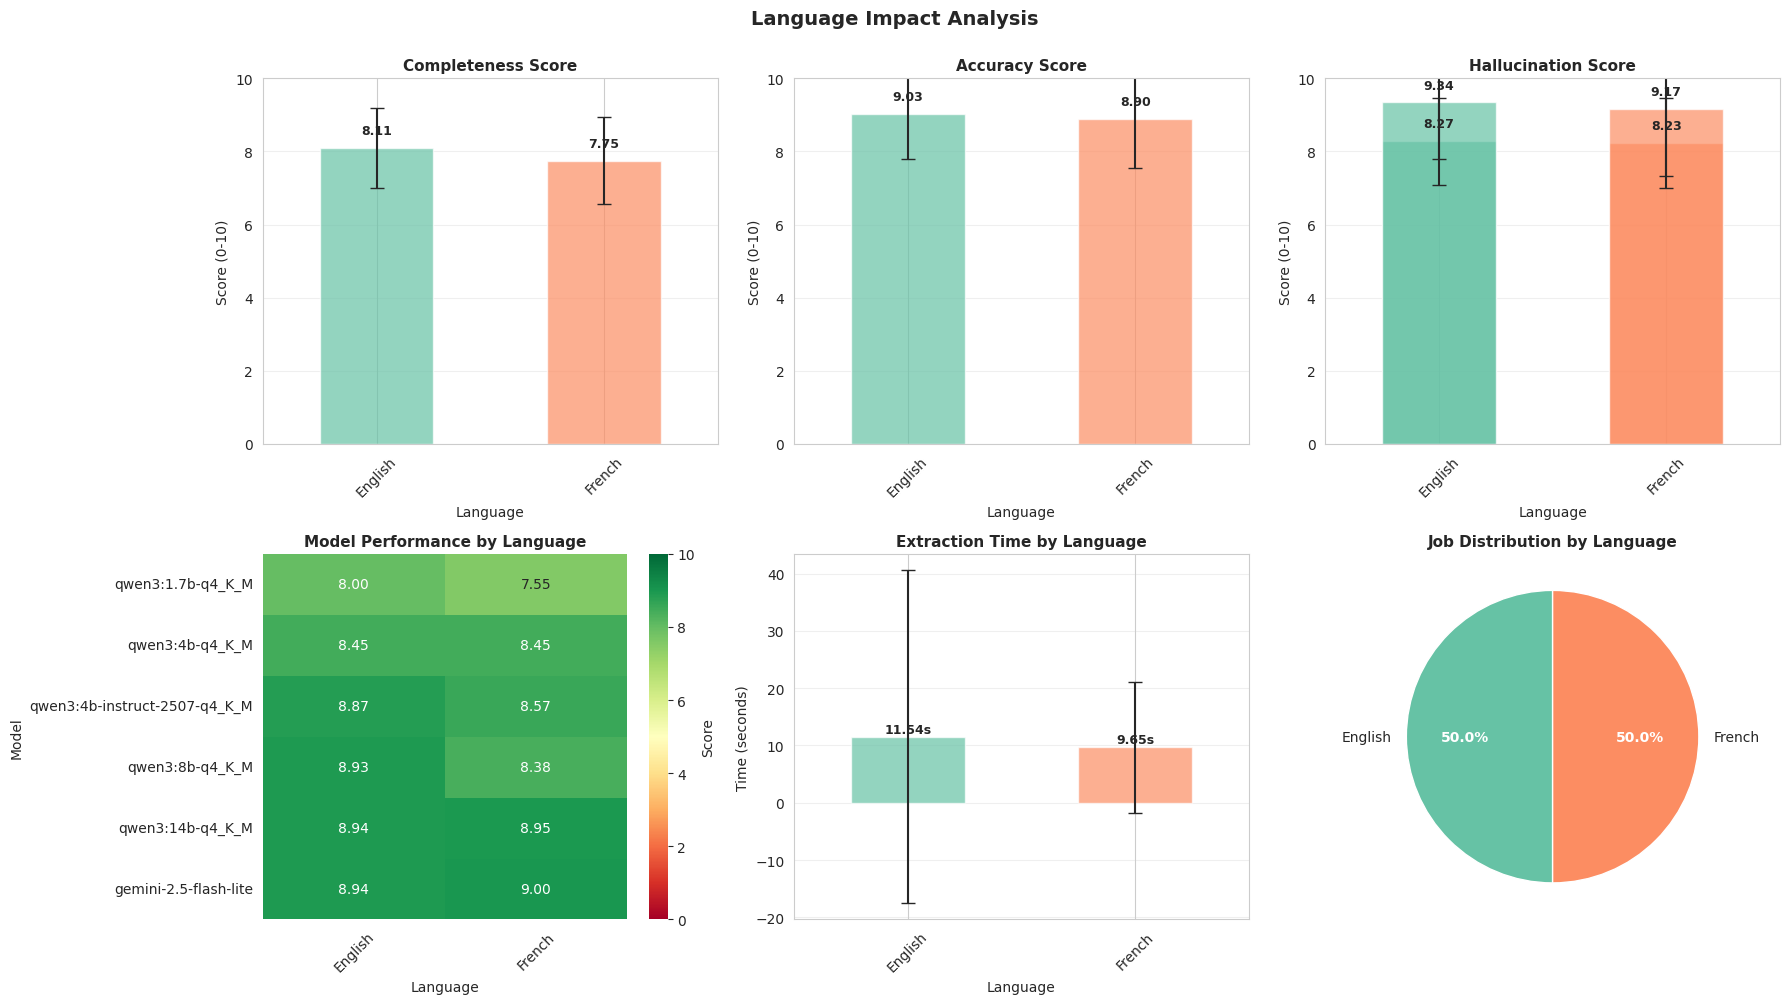

✓ Saved: figs/language_analysis.png

=== LANGUAGE STATISTICS ===
                     completeness_score       accuracy_score        \
                                   mean   std           mean   std   
description_language                                                 
English                            8.11  1.09           9.03  1.23   
French                             7.75  1.18           8.90  1.36   

                     specificity_score       hallucination_score        \
                                  mean   std                mean   std   
description_language                                                     
English                           8.27  1.20                9.34  1.54   
French                            8.23  1.22                9.17  1.85   

                     extraction_time         
                                mean    std  
description_language                         
English                        11.54  29.02  
French                       

In [27]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# Quality metrics by language
for ax, metric in zip(axes[0], metrics[:3]):
    if metric in results_df.columns:
        lang_data = results_df.groupby("description_language")[metric].agg(["mean", "std"])
        if not lang_data.empty:
            colors = plt.cm.Set2(range(len(lang_data)))
            lang_data["mean"].plot(kind='bar', ax=ax, yerr=lang_data["std"],
                                  capsize=5, color=colors, alpha=0.7)
            ax.set_title(f"{metric.replace('_', ' ').title()}", fontsize=11, fontweight='bold')
            ax.set_xlabel("Language", fontsize=10)
            ax.set_ylabel("Score (0-10)", fontsize=10)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(axis='y', alpha=0.3)
            ax.set_ylim(0, 10)
            # Add value labels
            for i, (idx, row) in enumerate(lang_data.iterrows()):
                ax.text(i, row["mean"] + 0.3, f'{row["mean"]:.2f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
# Hallucination score by language
ax = axes[0, 2]
if "hallucination_score" in results_df.columns:
    lang_data = results_df.groupby("description_language")["hallucination_score"].agg(["mean", "std"])
    if not lang_data.empty:
        colors = plt.cm.Set2(range(len(lang_data)))
        lang_data["mean"].plot(kind='bar', ax=ax, yerr=lang_data["std"],
                              capsize=5, color=colors, alpha=0.7)
        ax.set_title("Hallucination Score", fontsize=11, fontweight='bold')
        ax.set_xlabel("Language", fontsize=10)
        ax.set_ylabel("Score (0-10)", fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)
        for i, (idx, row) in enumerate(lang_data.iterrows()):
            ax.text(i, row["mean"] + 0.3, f'{row["mean"]:.2f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
# Model performance by language (heatmap)
ax = axes[1, 0]
if all(m in results_df.columns for m in metrics):
    results_df["overall_score"] = results_df[metrics].mean(axis=1)
    lang_model_perf = results_df.pivot_table(
        values="overall_score",
        index="extraction_model",
        columns="description_language",
        aggfunc="mean"
    )
    if not lang_model_perf.empty:
        sns.heatmap(lang_model_perf, annot=True, fmt='.2f', cmap='RdYlGn',
                   ax=ax, vmin=0, vmax=10, cbar_kws={'label': 'Score'})
        ax.set_title("Model Performance by Language", fontsize=11, fontweight='bold')
        ax.set_xlabel("Language", fontsize=10)
        ax.set_ylabel("Model", fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)
# Extraction time by language
ax = axes[1, 1]
if "extraction_time" in results_df.columns:
    time_data = results_df.groupby("description_language")["extraction_time"].agg(["mean", "std"])
    if not time_data.empty:
        colors = plt.cm.Set2(range(len(time_data)))
        time_data["mean"].plot(kind='bar', ax=ax, yerr=time_data["std"],
                              capsize=5, color=colors, alpha=0.7)
        ax.set_title("Extraction Time by Language", fontsize=11, fontweight='bold')
        ax.set_xlabel("Language", fontsize=10)
        ax.set_ylabel("Time (seconds)", fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
        for i, (idx, row) in enumerate(time_data.iterrows()):
            ax.text(i, row["mean"] + 0.2, f'{row["mean"]:.2f}s',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
# Sample distribution by language
ax = axes[1, 2]
if "description_language" in results_df.columns:
    lang_counts = results_df.groupby("description_language")["job_id"].nunique()
    if not lang_counts.empty:
        colors = plt.cm.Set2(range(len(lang_counts)))
        wedges, texts, autotexts = ax.pie(
            lang_counts.values,
            labels=lang_counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors
        )
        ax.set_title("Job Distribution by Language", fontsize=11, fontweight='bold')
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
plt.suptitle("Language Impact Analysis", y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("figs/language_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figs/language_analysis.png")
# Statistical summary
print("\n=== LANGUAGE STATISTICS ===")
lang_stats = results_df.groupby("description_language")[metrics + ["extraction_time"]].agg(["mean", "std"]).round(2)
print(lang_stats)
print("\n=== JOB COUNTS BY LANGUAGE ===")
print(results_df.groupby("description_language")["job_id"].nunique())

## Prompt Type Comparison (Direct vs Examples)

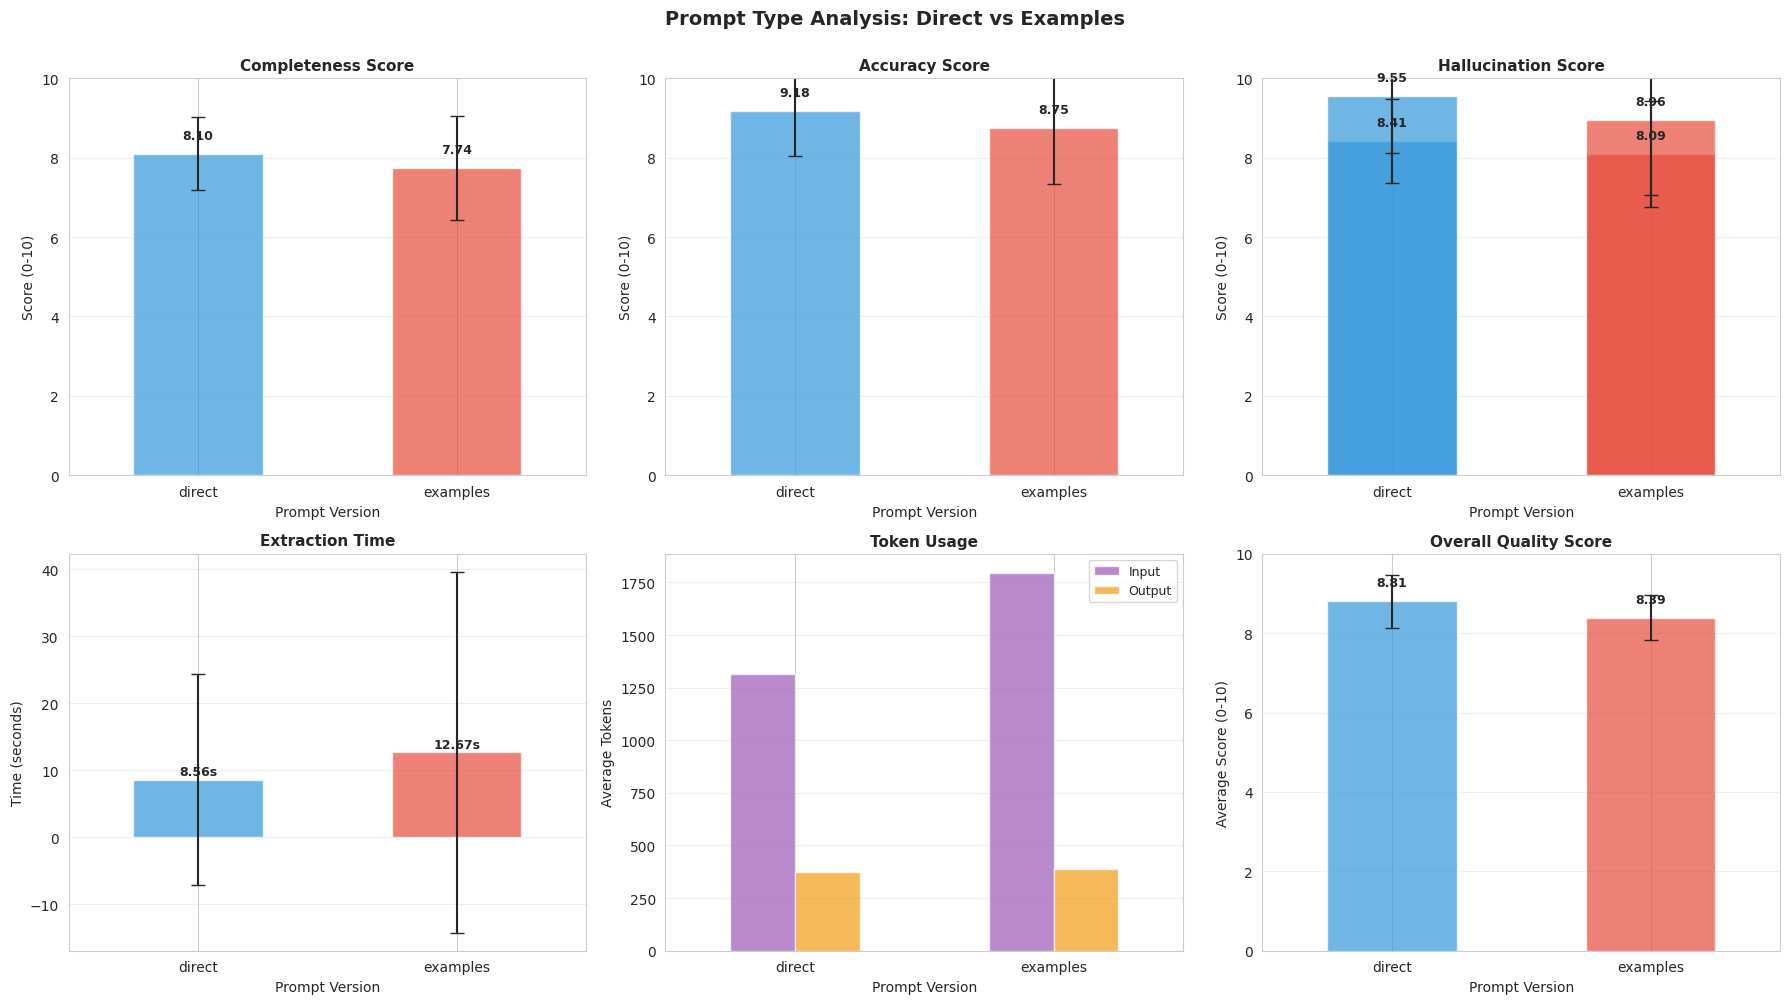

✓ Saved: prompt_comparison.png

=== PROMPT TYPE STATISTICS ===
               completeness_score       accuracy_score        \
                             mean   std           mean   std   
prompt_version                                                 
direct                       8.10  0.93           9.18  1.14   
examples                     7.74  1.32           8.75  1.40   

               specificity_score       hallucination_score        \
                            mean   std                mean   std   
prompt_version                                                     
direct                      8.41  1.05                9.55  1.42   
examples                    8.09  1.33                8.96  1.90   

               extraction_time         
                          mean    std  
prompt_version                         
direct                    8.56  15.74  
examples                 12.67  26.91  


In [28]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# Quality metrics comparison by prompt
for ax, metric in zip(axes[0], metrics[:3]):
    if metric in results_df.columns:
        prompt_data = results_df.groupby("prompt_version")[metric].agg(["mean", "std"])
        if not prompt_data.empty:
            prompt_data["mean"].plot(kind='bar', ax=ax, yerr=prompt_data["std"],
                                    capsize=5, color=['#3498db', '#e74c3c'], alpha=0.7)
            ax.set_title(f"{metric.replace('_', ' ').title()}", fontsize=11, fontweight='bold')
            ax.set_xlabel("Prompt Version", fontsize=10)
            ax.set_ylabel("Score (0-10)", fontsize=10)
            ax.tick_params(axis='x', rotation=0)
            ax.grid(axis='y', alpha=0.3)
            ax.set_ylim(0, 10)
            # Add value labels
            for i, (idx, row) in enumerate(prompt_data.iterrows()):
                ax.text(i, row["mean"] + 0.3, f'{row["mean"]:.2f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
# Hallucination score
ax = axes[0, 2]
if "hallucination_score" in results_df.columns:
    prompt_data = results_df.groupby("prompt_version")["hallucination_score"].agg(["mean", "std"])
    if not prompt_data.empty:
        prompt_data["mean"].plot(kind='bar', ax=ax, yerr=prompt_data["std"],
                                capsize=5, color=['#3498db', '#e74c3c'], alpha=0.7)
        ax.set_title("Hallucination Score", fontsize=11, fontweight='bold')
        ax.set_xlabel("Prompt Version", fontsize=10)
        ax.set_ylabel("Score (0-10)", fontsize=10)
        ax.tick_params(axis='x', rotation=0)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)
        for i, (idx, row) in enumerate(prompt_data.iterrows()):
            ax.text(i, row["mean"] + 0.3, f'{row["mean"]:.2f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
# Extraction time by prompt
ax = axes[1, 0]
if "extraction_time" in results_df.columns:
    time_data = results_df.groupby("prompt_version")["extraction_time"].agg(["mean", "std"])
    if not time_data.empty:
        time_data["mean"].plot(kind='bar', ax=ax, yerr=time_data["std"],
                              capsize=5, color=['#3498db', '#e74c3c'], alpha=0.7)
        ax.set_title("Extraction Time", fontsize=11, fontweight='bold')
        ax.set_xlabel("Prompt Version", fontsize=10)
        ax.set_ylabel("Time (seconds)", fontsize=10)
        ax.tick_params(axis='x', rotation=0)
        ax.grid(axis='y', alpha=0.3)
        for i, (idx, row) in enumerate(time_data.iterrows()):
            ax.text(i, row["mean"] + 0.2, f'{row["mean"]:.2f}s',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
# Token usage by prompt
ax = axes[1, 1]
if "input_tokens" in results_df.columns and "output_tokens" in results_df.columns:
    token_data = results_df.groupby("prompt_version")[["input_tokens", "output_tokens"]].mean()
    if not token_data.empty:
        token_data.plot(kind='bar', ax=ax, color=['#9b59b6', '#f39c12'], alpha=0.7)
        ax.set_title("Token Usage", fontsize=11, fontweight='bold')
        ax.set_xlabel("Prompt Version", fontsize=10)
        ax.set_ylabel("Average Tokens", fontsize=10)
        ax.tick_params(axis='x', rotation=0)
        ax.legend(["Input", "Output"], fontsize=9)
        ax.grid(axis='y', alpha=0.3)
# Overall quality by prompt
ax = axes[1, 2]
if all(m in results_df.columns for m in metrics):
    overall_data = results_df.groupby("prompt_version")[metrics].mean().mean(axis=1)
    overall_data_std = results_df.groupby("prompt_version")[metrics].mean().std(axis=1)
    if not overall_data.empty:
        overall_data.plot(kind='bar', ax=ax, yerr=overall_data_std,
                        capsize=5, color=['#3498db', '#e74c3c'], alpha=0.7)
        ax.set_title("Overall Quality Score", fontsize=11, fontweight='bold')
        ax.set_xlabel("Prompt Version", fontsize=10)
        ax.set_ylabel("Average Score (0-10)", fontsize=10)
        ax.tick_params(axis='x', rotation=0)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)
        for i, val in enumerate(overall_data):
            ax.text(i, val + 0.3, f'{val:.2f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.suptitle("Prompt Type Analysis: Direct vs Examples", y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("prompt_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: prompt_comparison.png")
# Statistical summary
print("\n=== PROMPT TYPE STATISTICS ===")
prompt_stats = results_df.groupby("prompt_version")[metrics + ["extraction_time"]].agg(["mean", "std"]).round(2)
print(prompt_stats)

## Overall Quality by Model and Prompt

/tmp/ipykernel_1173433/1812551708.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  model_prompt_quality = results_df.pivot_table(
/tmp/ipykernel_1173433/1812551708.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  completeness_pivot = results_df.pivot_table(
/tmp/ipykernel_1173433/1812551708.py:49: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  accuracy_pivot = results_df.pivot_table(
/tmp/ipykernel_1173433/1812551708.py:68: FutureWarning: The default value of observed=False is deprecated and will 

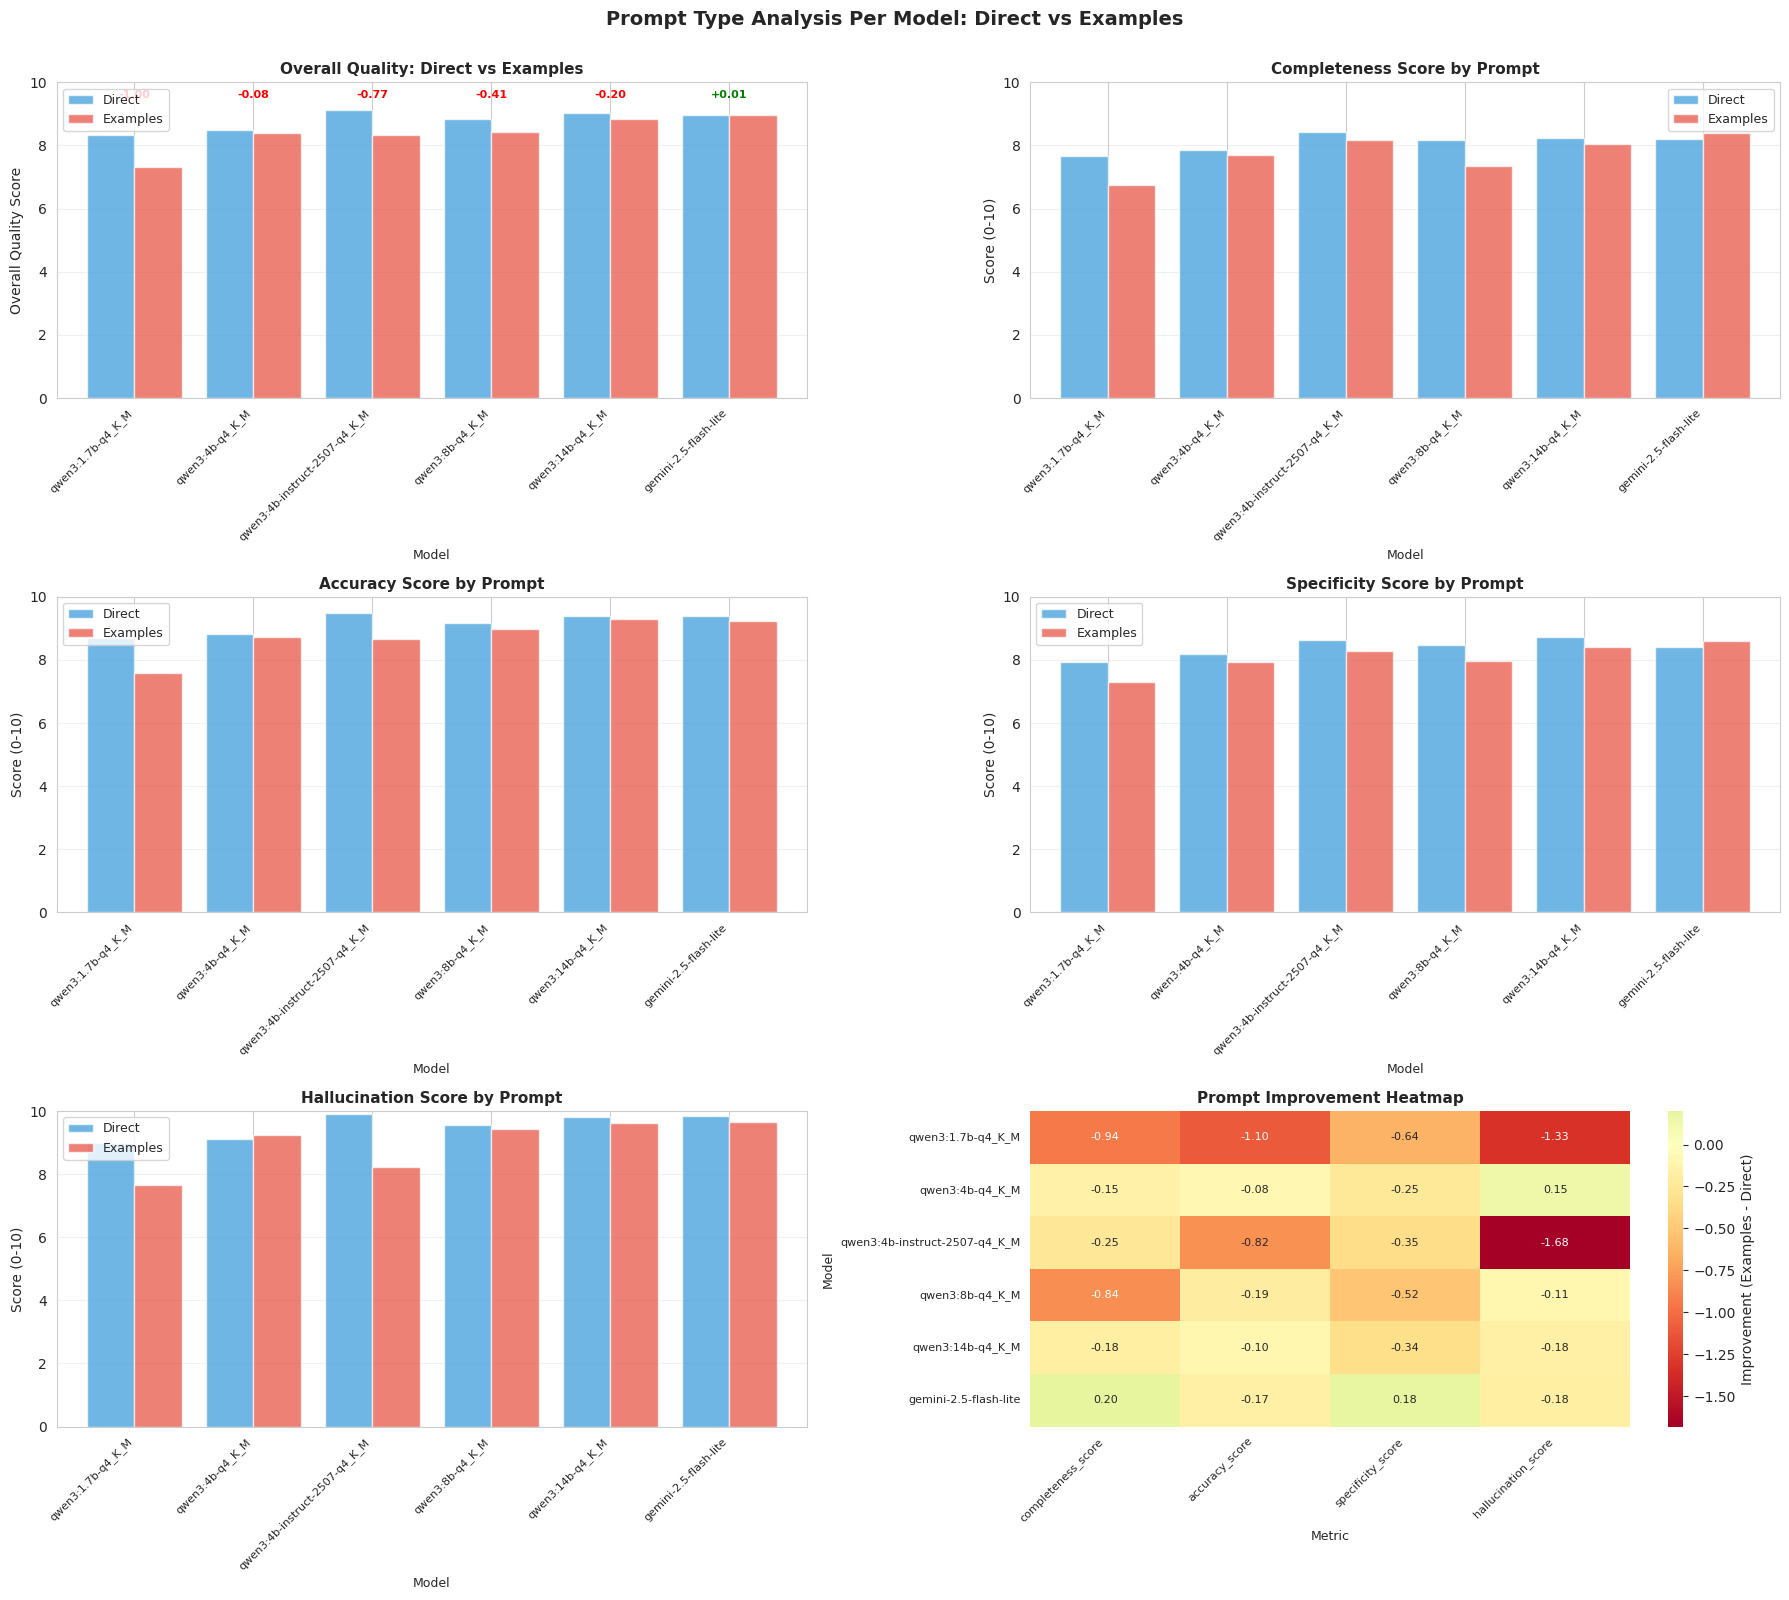

✓ Saved: figs/prompt_per_model_analysis.png

DETAILED PROMPT ANALYSIS PER MODEL

────────────────────────────────────────────────────────────────────────────────
MODEL: gemini-2.5-flash-lite
────────────────────────────────────────────────────────────────────────────────

                          DIRECT    EXAMPLES   IMPROVEMENT
                          ------    --------   -----------
completeness_score          8.20      8.40      +0.20 ✓
accuracy_score              9.40      9.23      -0.17 ✗
specificity_score           8.42      8.60      +0.18 ✓
hallucination_score         9.83      9.65      -0.18 ✗
────────────────────────────────────────────────────────────────────────────────
OVERALL QUALITY             8.96      8.97      +0.01 ✓

Input Tokens (avg)          1486      1895       +409
Extraction Time (avg)       1.85s     2.08s     +0.23s

RECOMMENDATION:          No significant difference (±0.01)

─────────────────────────────────────────────────────────────────────────────

/tmp/ipykernel_1173433/1812551708.py:209: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_improvement = results_df.groupby(["extraction_model", "prompt_version"])[metrics].mean().reset_index()
/tmp/ipykernel_1173433/1812551708.py:211: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  improvement_pivot = avg_improvement.pivot_table(values="overall", index="extraction_model", columns="prompt_version")


In [29]:

fig, axes = plt.subplots(3, 2, figsize=(18, 16))
ax = axes[0, 0]
if all(m in results_df.columns for m in metrics):
    results_df["overall_quality"] = results_df[metrics].mean(axis=1)
    model_prompt_quality = results_df.pivot_table(
        values="overall_quality",
        index="extraction_model",
        columns="prompt_version",
        aggfunc="mean"
    )
    if not model_prompt_quality.empty:
        model_prompt_quality.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'], alpha=0.7, width=0.8)
        ax.set_title("Overall Quality: Direct vs Examples", fontsize=11, fontweight='bold')
        ax.set_xlabel("Model", fontsize=9)
        ax.set_ylabel("Overall Quality Score", fontsize=10)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.legend(["Direct", "Examples"], fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)
        # Add difference annotations
        for i, model in enumerate(model_prompt_quality.index):
            if 'direct' in model_prompt_quality.columns and 'examples' in model_prompt_quality.columns:
                diff = model_prompt_quality.loc[model, 'examples'] - model_prompt_quality.loc[model, 'direct']
                color = 'green' if diff > 0 else 'red'
                ax.text(i, 9.5, f'{diff:+.2f}', ha='center', fontsize=8, color=color, fontweight='bold')
# 2. Completeness Score by Model and Prompt
ax = axes[0, 1]
if "completeness_score" in results_df.columns:
    completeness_pivot = results_df.pivot_table(
        values="completeness_score",
        index="extraction_model",
        columns="prompt_version",
        aggfunc="mean"
    )
    if not completeness_pivot.empty:
        completeness_pivot.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'], alpha=0.7, width=0.8)
        ax.set_title("Completeness Score by Prompt", fontsize=11, fontweight='bold')
        ax.set_xlabel("Model", fontsize=9)
        ax.set_ylabel("Score (0-10)", fontsize=10)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.legend(["Direct", "Examples"], fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)
# 3. Accuracy Score by Model and Prompt
ax = axes[1, 0]
if "accuracy_score" in results_df.columns:
    accuracy_pivot = results_df.pivot_table(
        values="accuracy_score",
        index="extraction_model",
        columns="prompt_version",
        aggfunc="mean"
    )
    if not accuracy_pivot.empty:
        accuracy_pivot.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'], alpha=0.7, width=0.8)
        ax.set_title("Accuracy Score by Prompt", fontsize=11, fontweight='bold')
        ax.set_xlabel("Model", fontsize=9)
        ax.set_ylabel("Score (0-10)", fontsize=10)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.legend(["Direct", "Examples"], fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)
# 4. Specificity Score by Model and Prompt
ax = axes[1, 1]
if "specificity_score" in results_df.columns:
    specificity_pivot = results_df.pivot_table(
        values="specificity_score",
        index="extraction_model",
        columns="prompt_version",
        aggfunc="mean"
    )
    if not specificity_pivot.empty:
        specificity_pivot.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'], alpha=0.7, width=0.8)
        ax.set_title("Specificity Score by Prompt", fontsize=11, fontweight='bold')
        ax.set_xlabel("Model", fontsize=9)
        ax.set_ylabel("Score (0-10)", fontsize=10)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.legend(["Direct", "Examples"], fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)
# 5. Hallucination Score by Model and Prompt
ax = axes[2, 0]
if "hallucination_score" in results_df.columns:
    hallucination_pivot = results_df.pivot_table(
        values="hallucination_score",
        index="extraction_model",
        columns="prompt_version",
        aggfunc="mean"
    )
    if not hallucination_pivot.empty:
        hallucination_pivot.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'], alpha=0.7, width=0.8)
        ax.set_title("Hallucination Score by Prompt", fontsize=11, fontweight='bold')
        ax.set_xlabel("Model", fontsize=9)
        ax.set_ylabel("Score (0-10)", fontsize=10)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.legend(["Direct", "Examples"], fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)
# 6. Prompt Improvement Heatmap
ax = axes[2, 1]
if all(m in results_df.columns for m in metrics):
    # Calculate improvement: Examples - Direct
    improvement_data = {}
    for model in results_df["extraction_model"].unique():
        model_data = results_df[results_df["extraction_model"] == model]
        direct_scores = model_data[model_data["prompt_version"] == "direct"][metrics].mean()
        examples_scores = model_data[model_data["prompt_version"] == "examples"][metrics].mean()
        improvement_data[model] = (examples_scores - direct_scores).to_dict()
    improvement_df = pd.DataFrame(improvement_data).T
    if not improvement_df.empty:
        sns.heatmap(improvement_df, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                   ax=ax, cbar_kws={'label': 'Improvement (Examples - Direct)'}, annot_kws={'fontsize': 8})
        ax.set_title("Prompt Improvement Heatmap", fontsize=11, fontweight='bold')
        ax.set_xlabel("Metric", fontsize=9)
        ax.set_ylabel("Model", fontsize=9)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', rotation=0, labelsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.suptitle("Prompt Type Analysis Per Model: Direct vs Examples", y=0.997, fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.995])
plt.savefig("figs/prompt_per_model_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figs/prompt_per_model_analysis.png")
# Detailed statistical analysis
print("\n" + "="*80)
print("DETAILED PROMPT ANALYSIS PER MODEL")
print("="*80)
for model in sorted(results_df["extraction_model"].unique()):
    model_data = results_df[results_df["extraction_model"] == model]
    direct_data = model_data[model_data["prompt_version"] == "direct"]
    examples_data = model_data[model_data["prompt_version"] == "examples"]
    print(f"\n{'─'*80}")
    print(f"MODEL: {model}")
    print(f"{'─'*80}")
    if len(direct_data) > 0 and len(examples_data) > 0:
        print("\n                          DIRECT    EXAMPLES   IMPROVEMENT")
        print("                          ------    --------   -----------")
        for metric in metrics:
            direct_mean = direct_data[metric].mean()
            examples_mean = examples_data[metric].mean()
            improvement = examples_mean - direct_mean
            better = "✓" if improvement > 0 else "✗"
            print(f"{metric:25s} {direct_mean:6.2f}    {examples_mean:6.2f}     {improvement:+6.2f} {better}")
        # Overall quality
        direct_overall = direct_data[metrics].mean().mean()
        examples_overall = examples_data[metrics].mean().mean()
        overall_improvement = examples_overall - direct_overall
        better = "✓" if overall_improvement > 0 else "✗"
        print(f"{'─'*80}")
        print(f"{'OVERALL QUALITY':25s} {direct_overall:6.2f}    {examples_overall:6.2f}     {overall_improvement:+6.2f} {better}")
        # Token efficiency
        direct_tokens = direct_data["input_tokens"].mean()
        examples_tokens = examples_data["input_tokens"].mean()
        token_diff = examples_tokens - direct_tokens
        print(f"\n{'Input Tokens (avg)':25s} {direct_tokens:6.0f}    {examples_tokens:6.0f}     {token_diff:+6.0f}")
        # Extraction time
        direct_time = direct_data["extraction_time"].mean()
        examples_time = examples_data["extraction_time"].mean()
        time_diff = examples_time - direct_time
        print(f"{'Extraction Time (avg)':25s} {direct_time:6.2f}s   {examples_time:6.2f}s    {time_diff:+6.2f}s")
        # Recommendation
        print(f"\n{'RECOMMENDATION:':<25s}", end="")
        if overall_improvement > 0.5:
            print(f"Use EXAMPLES prompt (significantly better: +{overall_improvement:.2f})")
        elif overall_improvement > 0.1:
            print(f"Slight preference for EXAMPLES prompt (+{overall_improvement:.2f})")
        elif overall_improvement > -0.1:
            print(f"No significant difference (±{abs(overall_improvement):.2f})")
        elif overall_improvement > -0.5:
            print(f"Slight preference for DIRECT prompt ({overall_improvement:.2f})")
        else:
            print(f"Use DIRECT prompt (significantly better: {overall_improvement:.2f})")
    else:
        print("  ⚠ Insufficient data for comparison")
print("\n" + "="*80)
print("SUMMARY: BEST PROMPT PER MODEL")
print("="*80)
summary_data = []
for model in sorted(results_df["extraction_model"].unique()):
    model_data = results_df[results_df["extraction_model"] == model]
    direct_data = model_data[model_data["prompt_version"] == "direct"]
    examples_data = model_data[model_data["prompt_version"] == "examples"]
    if len(direct_data) > 0 and len(examples_data) > 0:
        direct_overall = direct_data[metrics].mean().mean()
        examples_overall = examples_data[metrics].mean().mean()
        improvement = examples_overall - direct_overall
        best_prompt = "EXAMPLES" if improvement > 0 else "DIRECT"
        summary_data.append({
            "Model": model,
            "Direct Score": f"{direct_overall:.2f}",
            "Examples Score": f"{examples_overall:.2f}",
            "Improvement": f"{improvement:+.2f}",
            "Best Prompt": best_prompt
        })
summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))
# Overall statistics
print("\n" + "="*80)
print("OVERALL STATISTICS")
print("="*80)
models_better_with_examples = sum(1 for row in summary_data if row["Best Prompt"] == "EXAMPLES")
models_better_with_direct = sum(1 for row in summary_data if row["Best Prompt"] == "DIRECT")
print(f"\nModels performing better with EXAMPLES: {models_better_with_examples}/{len(summary_data)}")
print(f"Models performing better with DIRECT:   {models_better_with_direct}/{len(summary_data)}")
avg_improvement = results_df.groupby(["extraction_model", "prompt_version"])[metrics].mean().reset_index()
avg_improvement["overall"] = avg_improvement[metrics].mean(axis=1)
improvement_pivot = avg_improvement.pivot_table(values="overall", index="extraction_model", columns="prompt_version")
if "examples" in improvement_pivot.columns and "direct" in improvement_pivot.columns:
    mean_improvement = (improvement_pivot["examples"] - improvement_pivot["direct"]).mean()
    print(f"\nAverage improvement with EXAMPLES prompt: {mean_improvement:+.2f} points")
print("\n✓ Analysis complete!")

# Additional Insights & Analysis

In [16]:

successful_df = results_df.copy()

/tmp/ipykernel_1173433/3366509832.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_judge_agreement = successful_df.groupby(["extraction_model", "judge_model"])["overall_quality"].mean().unstack()
/tmp/ipykernel_1173433/3366509832.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  judge_scores_pivot = successful_df.groupby(["extraction_model", "judge_model"])["overall_quality"].mean().unstack()


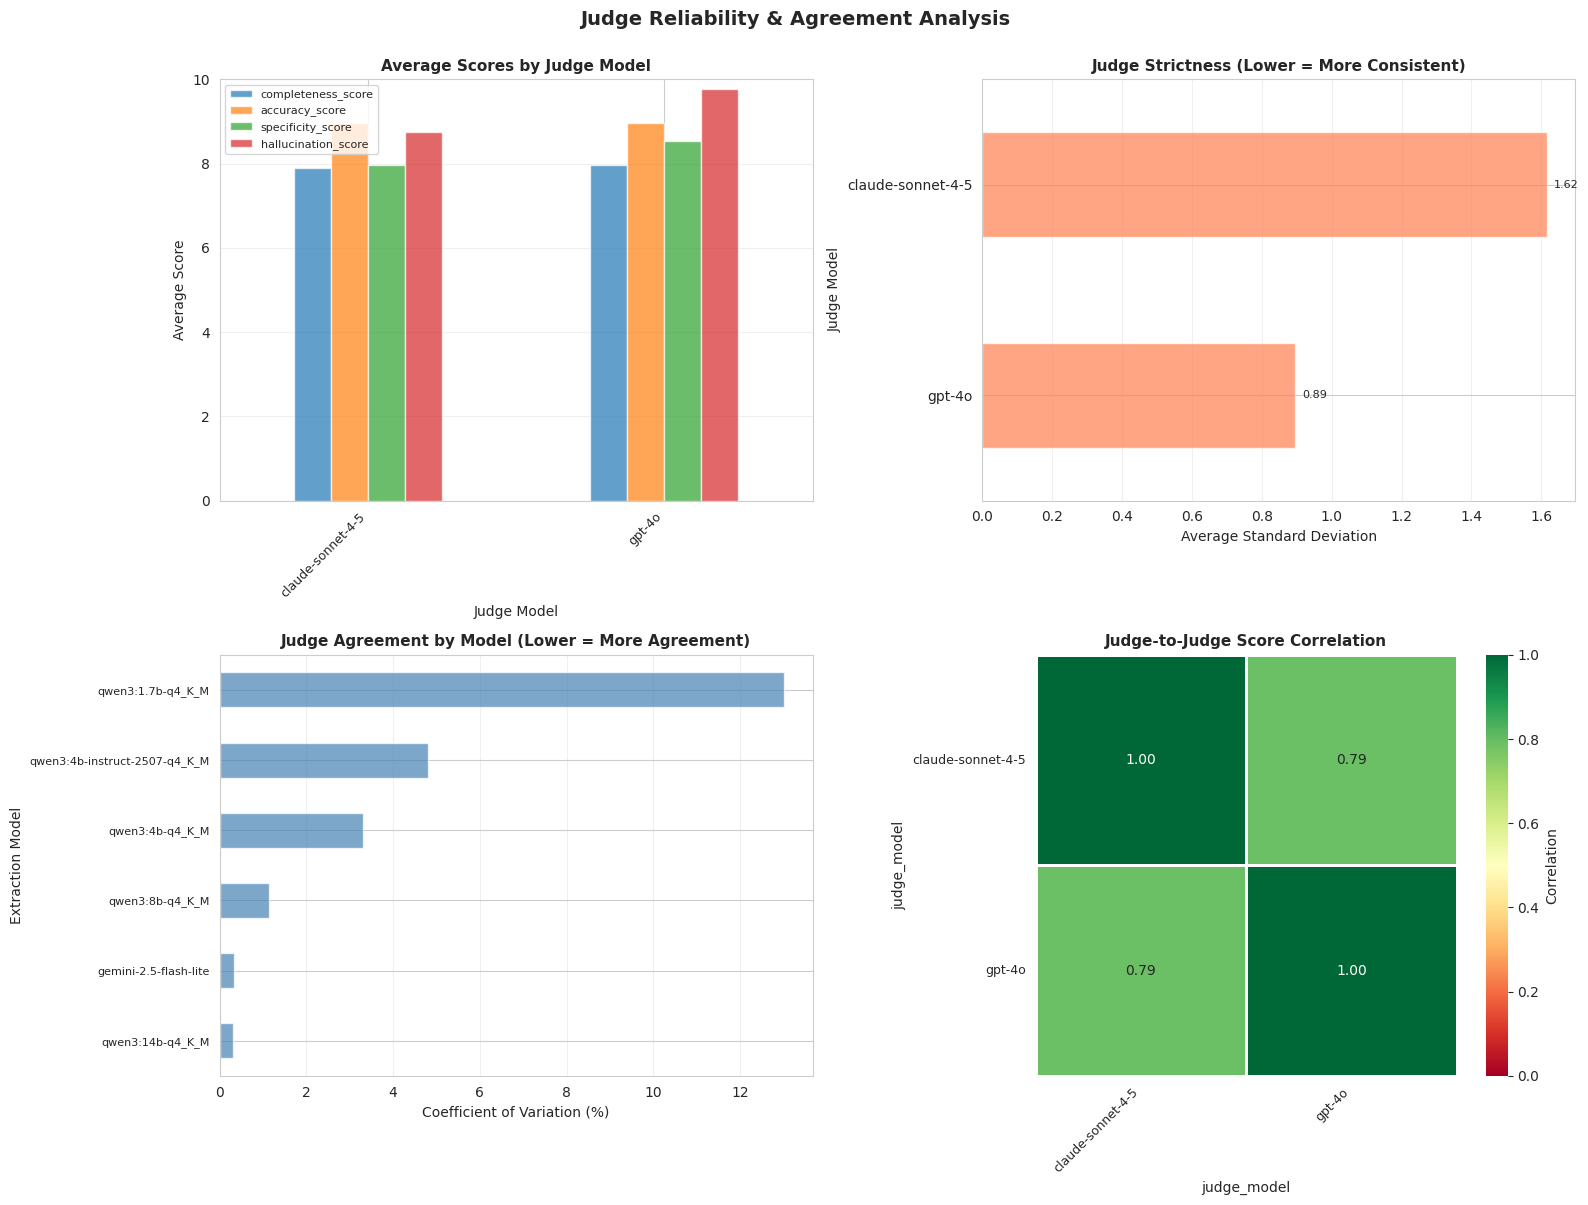

✓ Saved: figs/judge_reliability_analysis.png

=== JUDGE STATISTICS ===

Most Lenient Judges (Highest Avg Score):
judge_model
gpt-4o               8.809211
claude-sonnet-4-5    8.392128
dtype: float64

Most Consistent Judges (Lowest Std Dev):
judge_model
gpt-4o               0.894628
claude-sonnet-4-5    1.616740
dtype: float64

Models with Highest Judge Agreement (Lowest CV):
extraction_model
qwen3:14b-q4_K_M                 0.306623
gemini-2.5-flash-lite            0.328581
qwen3:8b-q4_K_M                  1.131955
qwen3:4b-q4_K_M                  3.310104
qwen3:4b-instruct-2507-q4_K_M    4.797380
dtype: float64


In [30]:
# Analysis 3: Judge Reliability & Agreement Analysis
# Analyze how different judges score and their agreement levels

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Judge Scoring Tendencies (Average scores given by each judge)
ax = axes[0, 0]
judge_avg_scores = successful_df.groupby("judge_model")[metrics].mean()

if not judge_avg_scores.empty:
    judge_avg_scores.plot(kind='bar', ax=ax, alpha=0.7)
    ax.set_title("Average Scores by Judge Model", fontsize=11, fontweight='bold')
    ax.set_xlabel("Judge Model", fontsize=10)
    ax.set_ylabel("Average Score", fontsize=10)
    ax.legend(metrics, fontsize=8, loc='best')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 10)

# 2. Judge Strictness (Standard deviation of scores)
ax = axes[0, 1]
judge_std = successful_df.groupby("judge_model")[metrics].std().mean(axis=1).sort_values()

if not judge_std.empty:
    judge_std.plot(kind='barh', ax=ax, color='coral', alpha=0.7)
    ax.set_title("Judge Strictness (Lower = More Consistent)", fontsize=11, fontweight='bold')
    ax.set_xlabel("Average Standard Deviation", fontsize=10)
    ax.set_ylabel("Judge Model", fontsize=10)
    ax.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, val in enumerate(judge_std):
        ax.text(val + 0.02, i, f'{val:.2f}', va='center', fontsize=8)

# 3. Judge Agreement on Models (Which models do judges agree/disagree on?)
ax = axes[1, 0]
# Calculate coefficient of variation for each model across judges
model_judge_agreement = successful_df.groupby(["extraction_model", "judge_model"])["overall_quality"].mean().unstack()

if not model_judge_agreement.empty:
    model_cv = (model_judge_agreement.std(axis=1) / model_judge_agreement.mean(axis=1) * 100).sort_values()
    model_cv.plot(kind='barh', ax=ax, color='steelblue', alpha=0.7)
    ax.set_title("Judge Agreement by Model (Lower = More Agreement)", fontsize=11, fontweight='bold')
    ax.set_xlabel("Coefficient of Variation (%)", fontsize=10)
    ax.set_ylabel("Extraction Model", fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    ax.tick_params(axis='y', labelsize=8)

# 4. Pairwise Judge Correlation
ax = axes[1, 1]
# Calculate average scores per extraction model and judge
judge_scores_pivot = successful_df.groupby(["extraction_model", "judge_model"])["overall_quality"].mean().unstack()

if not judge_scores_pivot.empty:
    judge_correlation = judge_scores_pivot.corr()
    sns.heatmap(judge_correlation, annot=True, fmt='.2f', cmap='RdYlGn',
               ax=ax, vmin=0, vmax=1, square=True, linewidths=1,
               cbar_kws={'label': 'Correlation'})
    ax.set_title("Judge-to-Judge Score Correlation", fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', rotation=0, labelsize=9)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle("Judge Reliability & Agreement Analysis", y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("figs/judge_reliability_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: figs/judge_reliability_analysis.png")
print("\n=== JUDGE STATISTICS ===")
print("\nMost Lenient Judges (Highest Avg Score):")
print(judge_avg_scores.mean(axis=1).sort_values(ascending=False).head())
print("\nMost Consistent Judges (Lowest Std Dev):")
print(judge_std.head())
print("\nModels with Highest Judge Agreement (Lowest CV):")
print(model_cv.head())

/tmp/ipykernel_1173433/778554472.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  lang_size_quality = successful_df.pivot_table(
/tmp/ipykernel_1173433/778554472.py:48: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  size_prompt_quality = successful_df.pivot_table(
/tmp/ipykernel_1173433/778554472.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_5_models = successful_df.groupby("extraction_model")["overall_quality"].mean().nlargest(5).index
/tmp/ipykernel_1173433/778

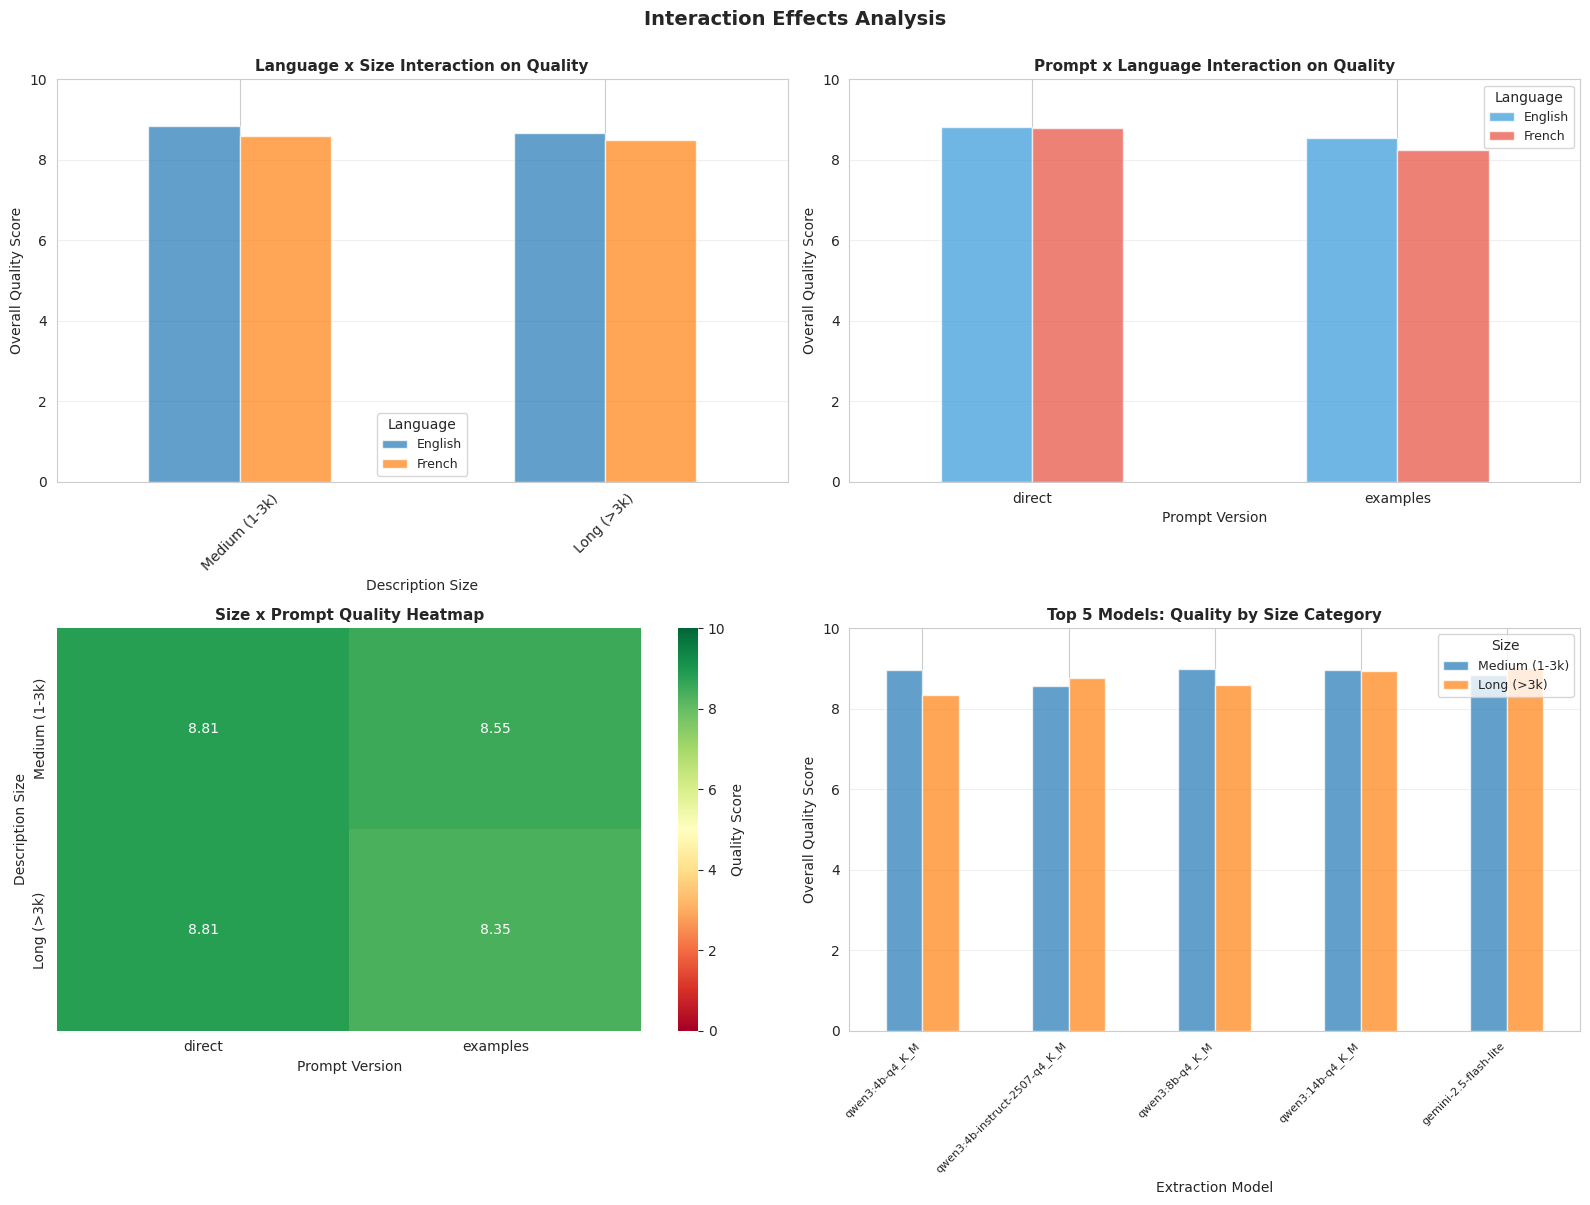

✓ Saved: figs/interaction_effects_analysis.png


In [31]:
# Analysis 5: Interaction Effects (Language x Size, Prompt x Size, etc.)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Language x Size Interaction
ax = axes[0, 0]
if "description_language" in successful_df.columns and "size_category" in successful_df.columns:
    lang_size_quality = successful_df.pivot_table(
        values="overall_quality",
        index="size_category",
        columns="description_language",
        aggfunc="mean"
    )

    if not lang_size_quality.empty:
        lang_size_quality.plot(kind='bar', ax=ax, alpha=0.7)
        ax.set_title("Language x Size Interaction on Quality", fontsize=11, fontweight='bold')
        ax.set_xlabel("Description Size", fontsize=10)
        ax.set_ylabel("Overall Quality Score", fontsize=10)
        ax.legend(title="Language", fontsize=9)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)

# 2. Prompt x Language Interaction
ax = axes[0, 1]
if "description_language" in successful_df.columns and "prompt_version" in successful_df.columns:
    prompt_lang_quality = successful_df.pivot_table(
        values="overall_quality",
        index="prompt_version",
        columns="description_language",
        aggfunc="mean"
    )

    if not prompt_lang_quality.empty:
        prompt_lang_quality.plot(kind='bar', ax=ax, alpha=0.7, color=['#3498db', '#e74c3c'])
        ax.set_title("Prompt x Language Interaction on Quality", fontsize=11, fontweight='bold')
        ax.set_xlabel("Prompt Version", fontsize=10)
        ax.set_ylabel("Overall Quality Score", fontsize=10)
        ax.legend(title="Language", fontsize=9)
        ax.tick_params(axis='x', rotation=0)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)

# 3. Size x Prompt Interaction Heatmap
ax = axes[1, 0]
if "size_category" in successful_df.columns and "prompt_version" in successful_df.columns:
    size_prompt_quality = successful_df.pivot_table(
        values="overall_quality",
        index="size_category",
        columns="prompt_version",
        aggfunc="mean"
    )

    if not size_prompt_quality.empty:
        sns.heatmap(size_prompt_quality, annot=True, fmt='.2f', cmap='RdYlGn',
                   ax=ax, vmin=0, vmax=10, cbar_kws={'label': 'Quality Score'})
        ax.set_title("Size x Prompt Quality Heatmap", fontsize=11, fontweight='bold')
        ax.set_xlabel("Prompt Version", fontsize=10)
        ax.set_ylabel("Description Size", fontsize=10)

# 4. Model Performance by Size Category
ax = axes[1, 1]
if "size_category" in successful_df.columns:
    # Get top 5 models
    top_5_models = successful_df.groupby("extraction_model")["overall_quality"].mean().nlargest(5).index
    size_model_quality = successful_df[successful_df["extraction_model"].isin(top_5_models)].pivot_table(
        values="overall_quality",
        index="extraction_model",
        columns="size_category",
        aggfunc="mean"
    )

    if not size_model_quality.empty:
        size_model_quality.plot(kind='bar', ax=ax, alpha=0.7)
        ax.set_title("Top 5 Models: Quality by Size Category", fontsize=11, fontweight='bold')
        ax.set_xlabel("Extraction Model", fontsize=10)
        ax.set_ylabel("Overall Quality Score", fontsize=10)
        ax.legend(title="Size", fontsize=9)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 10)

plt.suptitle("Interaction Effects Analysis", y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("figs/interaction_effects_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: figs/interaction_effects_analysis.png")

# Error & Judge Feedback Analysis

**Important:** Run the analysis cells below in order. They create the necessary count columns (`missing_count`, `generic_count`, `fabricated_count`) used in later visualizations.

In [32]:
# Analysis 1: Missing Critical Information Analysis
print("="*80)
print(" "*20 + "MISSING CRITICAL INFORMATION ANALYSIS")
print("="*80)

if 'missing_critical_info' in results_df.columns:
    # Parse the missing info lists (handle both list and string representations)
    def parse_list_column(x):
        if isinstance(x, list):
            return x
        elif isinstance(x, str):
            import ast
            try:
                return ast.literal_eval(x)
            except:
                return []
        else:
            return []

    results_df['missing_critical_info_parsed'] = results_df['missing_critical_info'].apply(parse_list_column)
    results_df['missing_count'] = results_df['missing_critical_info_parsed'].apply(len)

    # Overall statistics
    print(f"\n📊 OVERVIEW:")
    print(f"  Total extractions with missing info: {(results_df['missing_count'] > 0).sum()}")
    print(f"  Average missing items per extraction: {results_df['missing_count'].mean():.2f}")
    print(f"  Max missing items: {results_df['missing_count'].max()}")

    # By model
    print(f"\n🤖 MISSING INFO BY MODEL:")
    missing_by_model = results_df.groupby('extraction_model')['missing_count'].agg(['mean', 'sum', 'count'])
    missing_by_model['pct_with_missing'] = (results_df.groupby('extraction_model')['missing_count']
                                            .apply(lambda x: (x > 0).sum() / len(x) * 100))
    missing_by_model = missing_by_model.sort_values('mean', ascending=False)
    print(missing_by_model.round(2))

    # Most commonly missed information across all extractions
    print(f"\n🔍 MOST COMMONLY MISSED INFORMATION:")
    all_missing = []
    for items in results_df['missing_critical_info_parsed']:
        all_missing.extend(items)

    from collections import Counter
    missing_counter = Counter(all_missing)

    if len(missing_counter) > 0:
        print(f"\nTop 15 most frequently missing items:")
        for item, count in missing_counter.most_common(15):
            pct = count / len(results_df) * 100
            print(f"  {count:4d} ({pct:5.1f}%) - {item[:100]}")
    else:
        print("  ✅ No missing information reported!")

    # By prompt version
    if 'prompt_version' in results_df.columns:
        print(f"\n📝 MISSING INFO BY PROMPT VERSION:")
        missing_by_prompt = results_df.groupby('prompt_version')['missing_count'].agg(['mean', 'median'])
        print(missing_by_prompt.round(2))

    # By description size
    if 'size_category' in results_df.columns:
        print(f"\n📏 MISSING INFO BY DESCRIPTION SIZE:")
        missing_by_size = results_df.groupby('size_category')['missing_count'].agg(['mean', 'median'])
        print(missing_by_size.round(2))

else:
    print("⚠️ 'missing_critical_info' column not found in dataset")

                    MISSING CRITICAL INFORMATION ANALYSIS

📊 OVERVIEW:
  Total extractions with missing info: 596
  Average missing items per extraction: 3.35
  Max missing items: 18

🤖 MISSING INFO BY MODEL:
                               mean  sum  count  pct_with_missing
extraction_model                                                 
qwen3:1.7b-q4_K_M              4.93  527    107             95.33
qwen3:4b-q4_K_M                3.50  385    110             83.64
qwen3:8b-q4_K_M                3.46  388    112             87.50
qwen3:4b-instruct-2507-q4_K_M  2.88  346    120             85.00
gemini-2.5-flash-lite          2.78  333    120             88.33
qwen3:14b-q4_K_M               2.74  318    116             82.76

🔍 MOST COMMONLY MISSED INFORMATION:

Top 15 most frequently missing items:
    28 (  4.1%) - Team size
    21 (  3.1%) - Reports to
    18 (  2.6%) - Remote work details
     8 (  1.2%) - Salary range ($106,200 to $210,000 USD)
     8 (  1.2%) - Seniority level


/tmp/ipykernel_1173433/1114908454.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_by_model = results_df.groupby('extraction_model')['missing_count'].agg(['mean', 'sum', 'count'])
/tmp/ipykernel_1173433/1114908454.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_by_model['pct_with_missing'] = (results_df.groupby('extraction_model')['missing_count']
/tmp/ipykernel_1173433/1114908454.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futur

In [33]:
# Analysis 2: Generic Extractions Analysis
print("="*80)
print(" "*20 + "GENERIC EXTRACTIONS ANALYSIS")
print("="*80)

if 'generic_extractions' in results_df.columns:
    # Parse the generic extraction lists
    def parse_list_column(x):
        if isinstance(x, list):
            return x
        elif isinstance(x, str):
            import ast
            try:
                return ast.literal_eval(x)
            except:
                return []
        else:
            return []

    results_df['generic_extractions_parsed'] = results_df['generic_extractions'].apply(parse_list_column)
    results_df['generic_count'] = results_df['generic_extractions_parsed'].apply(len)

    # Overall statistics
    print(f"\n📊 OVERVIEW:")
    print(f"  Total extractions with generic info: {(results_df['generic_count'] > 0).sum()}")
    print(f"  Average generic items per extraction: {results_df['generic_count'].mean():.2f}")
    print(f"  Max generic items: {results_df['generic_count'].max()}")

    # By model
    print(f"\n🤖 GENERIC EXTRACTIONS BY MODEL:")
    generic_by_model = results_df.groupby('extraction_model')['generic_count'].agg(['mean', 'sum', 'count'])
    generic_by_model['pct_with_generic'] = (results_df.groupby('extraction_model')['generic_count']
                                            .apply(lambda x: (x > 0).sum() / len(x) * 100))
    generic_by_model = generic_by_model.sort_values('mean', ascending=False)
    print(generic_by_model.round(2))

    # Most commonly generic extractions
    print(f"\n🔍 MOST COMMON GENERIC EXTRACTIONS:")
    all_generic = []
    for items in results_df['generic_extractions_parsed']:
        all_generic.extend(items)

    from collections import Counter
    generic_counter = Counter(all_generic)

    if len(generic_counter) > 0:
        print(f"\nTop 15 most common generic extractions:")
        for item, count in generic_counter.most_common(15):
            pct = count / len(results_df) * 100
            print(f"  {count:4d} ({pct:5.1f}%) - {item[:100]}")
    else:
        print("  ✅ No generic extractions reported!")

    # Correlation with specificity score
    if 'specificity_score' in results_df.columns:
        corr = results_df['generic_count'].corr(results_df['specificity_score'])
        print(f"\n📈 Correlation between generic count and specificity score: {corr:.3f}")
        print(f"   (Negative correlation expected - more generic = lower specificity)")

else:
    print("⚠️ 'generic_extractions' column not found in dataset")

                    GENERIC EXTRACTIONS ANALYSIS

📊 OVERVIEW:
  Total extractions with generic info: 486
  Average generic items per extraction: 1.46
  Max generic items: 9

🤖 GENERIC EXTRACTIONS BY MODEL:
                               mean  sum  count  pct_with_generic
extraction_model                                                 
qwen3:1.7b-q4_K_M              1.69  181    107             79.44
qwen3:4b-q4_K_M                1.55  171    110             75.45
qwen3:8b-q4_K_M                1.46  163    112             71.43
qwen3:4b-instruct-2507-q4_K_M  1.44  173    120             68.33
gemini-2.5-flash-lite          1.44  173    120             65.83
qwen3:14b-q4_K_M               1.19  138    116             66.38

🔍 MOST COMMON GENERIC EXTRACTIONS:

Top 15 most common generic extractions:
    39 (  5.7%) - reports_to
    38 (  5.5%) - team_size
    22 (  3.2%) - seniority_level
    21 (  3.1%) - experience_years_max
    19 (  2.8%) - remote_details
    19 (  2.8%) - experien

/tmp/ipykernel_1173433/1536489241.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  generic_by_model = results_df.groupby('extraction_model')['generic_count'].agg(['mean', 'sum', 'count'])
/tmp/ipykernel_1173433/1536489241.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  generic_by_model['pct_with_generic'] = (results_df.groupby('extraction_model')['generic_count']


In [34]:
# Analysis 3: Fabricated/Hallucinated Information Analysis
print("="*80)
print(" "*20 + "FABRICATED INFORMATION ANALYSIS")
print("="*80)

if 'fabricated_info' in results_df.columns:
    # Parse the fabricated info lists
    def parse_list_column(x):
        if isinstance(x, list):
            return x
        elif isinstance(x, str):
            import ast
            try:
                return ast.literal_eval(x)
            except:
                return []
        else:
            return []

    results_df['fabricated_info_parsed'] = results_df['fabricated_info'].apply(parse_list_column)
    if 'fabricated_count' not in results_df.columns:
        results_df['fabricated_count'] = results_df['fabricated_info_parsed'].apply(len)

    # Overall statistics
    print(f"\n📊 OVERVIEW:")
    total_with_fabrications = (results_df['fabricated_count'] > 0).sum()
    print(f"  Total extractions with fabricated info: {total_with_fabrications}")
    print(f"  Percentage with fabrications: {total_with_fabrications / len(results_df) * 100:.1f}%")
    print(f"  Average fabricated items per extraction: {results_df['fabricated_count'].mean():.2f}")
    if results_df['fabricated_count'].max() > 0:
        print(f"  Max fabricated items: {results_df['fabricated_count'].max()}")

    # By model
    print(f"\n🤖 FABRICATIONS BY MODEL:")
    fab_by_model = results_df.groupby('extraction_model')['fabricated_count'].agg(['mean', 'sum', 'count'])
    fab_by_model['pct_with_fabrications'] = (results_df.groupby('extraction_model')['fabricated_count']
                                             .apply(lambda x: (x > 0).sum() / len(x) * 100))
    fab_by_model = fab_by_model.sort_values('pct_with_fabrications', ascending=False)
    print(fab_by_model.round(2))

    # Examples of fabricated information
    print(f"\n🔍 FABRICATION DETAILS:")
    all_fabricated = []
    for items in results_df['fabricated_info_parsed']:
        all_fabricated.extend(items)

    if len(all_fabricated) > 0:
        from collections import Counter
        fab_counter = Counter(all_fabricated)

        print(f"\nTotal fabricated items found: {len(all_fabricated)}")
        print(f"\nTop 10 fabricated items (if recurring):")
        for item, count in fab_counter.most_common(10):
            if count > 1:  # Only show if it occurred multiple times
                pct = count / len(results_df) * 100
                print(f"  {count:4d} ({pct:5.1f}%) - {item[:100]}")

        # Show some unique examples
        print(f"\n🔴 Sample unique fabrications:")
        unique_fabs = [item for item, count in fab_counter.items() if count == 1]
        for fab in unique_fabs[:5]:
            print(f"  - {fab[:150]}")
    else:
        print("  ✅ No fabricated information found! All models are honest.")

    # Correlation with hallucination score
    if 'hallucination_score' in results_df.columns and results_df['fabricated_count'].max() > 0:
        corr = results_df['fabricated_count'].corr(results_df['hallucination_score'])
        print(f"\n📈 Correlation between fabrication count and hallucination score: {corr:.3f}")
        print(f"   (Negative correlation expected - more fabrications = lower hallucination score)")

else:
    print("⚠️ 'fabricated_info' column not found in dataset")

                    FABRICATED INFORMATION ANALYSIS

📊 OVERVIEW:
  Total extractions with fabricated info: 156
  Percentage with fabrications: 22.8%
  Average fabricated items per extraction: 0.57
  Max fabricated items: 8

🤖 FABRICATIONS BY MODEL:
                               mean  sum  count  pct_with_fabrications
extraction_model                                                      
qwen3:1.7b-q4_K_M              1.19  127    107                  44.86
qwen3:4b-instruct-2507-q4_K_M  0.95  114    120                  31.67
qwen3:4b-q4_K_M                0.55   60    110                  25.45
qwen3:8b-q4_K_M                0.34   38    112                  12.50
gemini-2.5-flash-lite          0.21   25    120                  12.50
qwen3:14b-q4_K_M               0.21   24    116                  11.21

🔍 FABRICATION DETAILS:

Total fabricated items found: 388

Top 10 fabricated items (if recurring):
     2 (  0.3%) - Python - not explicitly mentioned in the job posting
     2 (  0.

/tmp/ipykernel_1173433/1221621229.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fab_by_model = results_df.groupby('extraction_model')['fabricated_count'].agg(['mean', 'sum', 'count'])
/tmp/ipykernel_1173433/1221621229.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fab_by_model['pct_with_fabrications'] = (results_df.groupby('extraction_model')['fabricated_count']


/tmp/ipykernel_1173433/2627202197.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_avg = results_df.groupby('extraction_model')['missing_count'].mean().sort_values(ascending=False)
/tmp/ipykernel_1173433/2627202197.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  generic_avg = results_df.groupby('extraction_model')['generic_count'].mean().sort_values(ascending=False)
/tmp/ipykernel_1173433/2627202197.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt

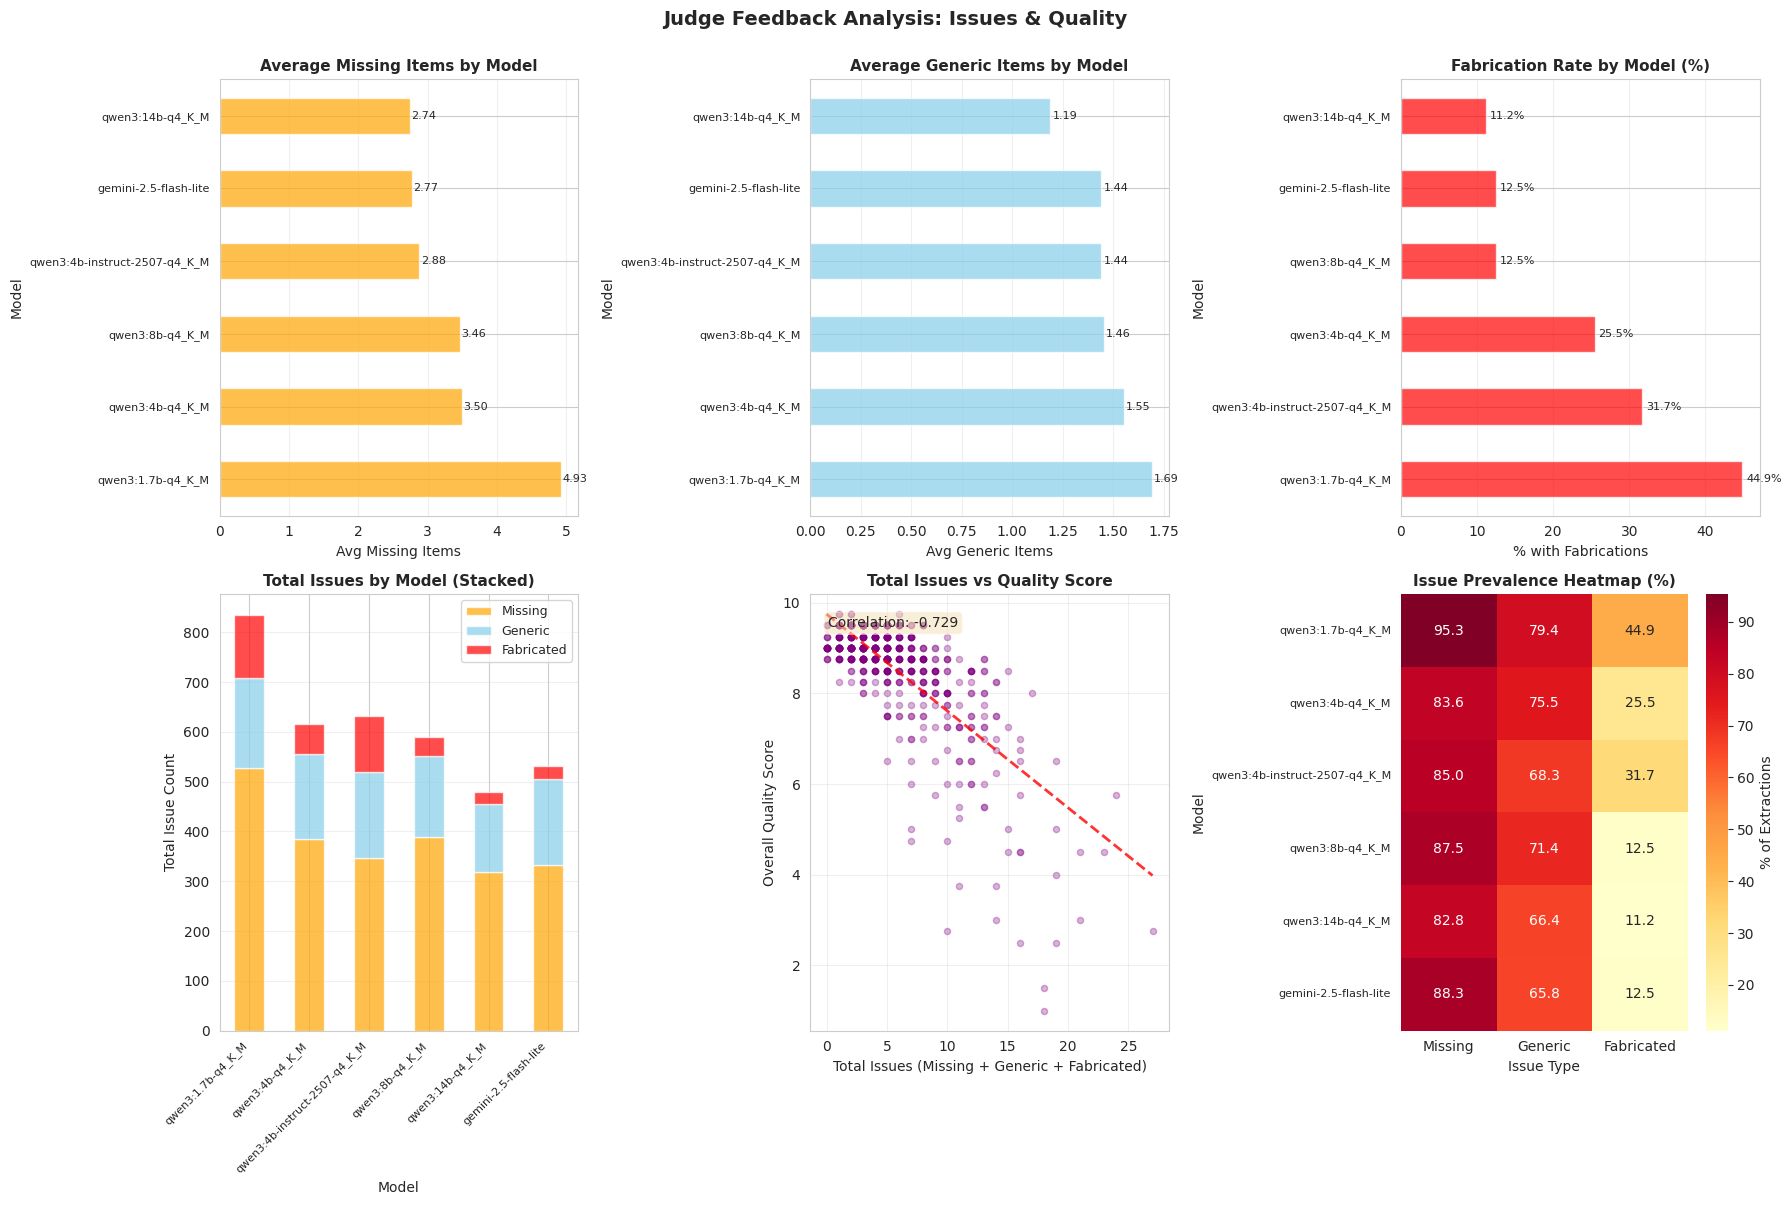

✓ Saved: figs/judge_feedback_analysis.png


In [35]:
# Visualization: Judge Feedback Overview

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Missing Info Count by Model
ax = axes[0, 0]
if 'missing_count' in results_df.columns:
    missing_avg = results_df.groupby('extraction_model')['missing_count'].mean().sort_values(ascending=False)
    missing_avg.plot(kind='barh', ax=ax, color='orange', alpha=0.7)
    ax.set_title("Average Missing Items by Model", fontsize=11, fontweight='bold')
    ax.set_xlabel("Avg Missing Items", fontsize=10)
    ax.set_ylabel("Model", fontsize=10)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(axis='x', alpha=0.3)

    for i, val in enumerate(missing_avg):
        ax.text(val + 0.02, i, f'{val:.2f}', va='center', fontsize=8)

# 2. Generic Extractions Count by Model
ax = axes[0, 1]
if 'generic_count' in results_df.columns:
    generic_avg = results_df.groupby('extraction_model')['generic_count'].mean().sort_values(ascending=False)
    generic_avg.plot(kind='barh', ax=ax, color='skyblue', alpha=0.7)
    ax.set_title("Average Generic Items by Model", fontsize=11, fontweight='bold')
    ax.set_xlabel("Avg Generic Items", fontsize=10)
    ax.set_ylabel("Model", fontsize=10)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(axis='x', alpha=0.3)

    for i, val in enumerate(generic_avg):
        ax.text(val + 0.01, i, f'{val:.2f}', va='center', fontsize=8)

# 3. Fabrication Rate by Model
ax = axes[0, 2]
if 'fabricated_count' in results_df.columns:
    fab_rate = results_df.groupby('extraction_model')['fabricated_count'].apply(
        lambda x: (x > 0).sum() / len(x) * 100
    ).sort_values(ascending=False)
    fab_rate.plot(kind='barh', ax=ax, color='red', alpha=0.7)
    ax.set_title("Fabrication Rate by Model (%)", fontsize=11, fontweight='bold')
    ax.set_xlabel("% with Fabrications", fontsize=10)
    ax.set_ylabel("Model", fontsize=10)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(axis='x', alpha=0.3)

    for i, val in enumerate(fab_rate):
        ax.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=8)

# 4. Issue Distribution (Stacked Bar)
ax = axes[1, 0]
if all(col in results_df.columns for col in ['missing_count', 'generic_count', 'fabricated_count']):
    issue_summary = results_df.groupby('extraction_model')[['missing_count', 'generic_count', 'fabricated_count']].sum()
    issue_summary.columns = ['Missing', 'Generic', 'Fabricated']

    issue_summary.plot(kind='bar', stacked=True, ax=ax,
                      color=['orange', 'skyblue', 'red'], alpha=0.7)
    ax.set_title("Total Issues by Model (Stacked)", fontsize=11, fontweight='bold')
    ax.set_xlabel("Model", fontsize=10)
    ax.set_ylabel("Total Issue Count", fontsize=10)
    ax.legend(fontsize=9)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

# 5. Issues vs Quality Score
ax = axes[1, 1]
if all(col in results_df.columns for col in ['missing_count', 'generic_count', 'fabricated_count', 'overall_quality']):
    results_df['total_issues'] = results_df['missing_count'] + results_df['generic_count'] + results_df['fabricated_count']

    # Scatter plot with trend line
    ax.scatter(results_df['total_issues'], results_df['overall_quality'],
              alpha=0.3, s=20, c='purple')

    # Add trend line
    z = np.polyfit(results_df['total_issues'], results_df['overall_quality'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(results_df['total_issues'].min(), results_df['total_issues'].max(), 100)
    ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

    ax.set_title("Total Issues vs Quality Score", fontsize=11, fontweight='bold')
    ax.set_xlabel("Total Issues (Missing + Generic + Fabricated)", fontsize=10)
    ax.set_ylabel("Overall Quality Score", fontsize=10)
    ax.grid(True, alpha=0.3)

    corr = results_df['total_issues'].corr(results_df['overall_quality'])
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}',
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 6. Issue Breakdown Heatmap
ax = axes[1, 2]
if all(col in results_df.columns for col in ['missing_count', 'generic_count', 'fabricated_count']):
    # Calculate percentage of extractions with each type of issue
    issue_pct = pd.DataFrame({
        'Missing': results_df.groupby('extraction_model')['missing_count'].apply(lambda x: (x > 0).sum() / len(x) * 100),
        'Generic': results_df.groupby('extraction_model')['generic_count'].apply(lambda x: (x > 0).sum() / len(x) * 100),
        'Fabricated': results_df.groupby('extraction_model')['fabricated_count'].apply(lambda x: (x > 0).sum() / len(x) * 100)
    })

    sns.heatmap(issue_pct, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
               cbar_kws={'label': '% of Extractions'})
    ax.set_title("Issue Prevalence Heatmap (%)", fontsize=11, fontweight='bold')
    ax.set_xlabel("Issue Type", fontsize=10)
    ax.set_ylabel("Model", fontsize=10)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

plt.suptitle("Judge Feedback Analysis: Issues & Quality", y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("figs/judge_feedback_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: figs/judge_feedback_analysis.png")

In [36]:
# Deep Dive: Categorizing Common Issues

print("="*80)
print(" "*20 + "COMMON ISSUE PATTERNS")
print("="*80)

# Analyze patterns in missing information
if 'missing_critical_info_parsed' in results_df.columns:
    print("\n📋 MISSING INFORMATION CATEGORIES:")

    all_missing = []
    for items in results_df['missing_critical_info_parsed']:
        all_missing.extend(items)

    if len(all_missing) > 0:
        # Categorize missing items
        categories = {
            'Salary/Compensation': [],
            'Location': [],
            'Experience': [],
            'Education': [],
            'Skills': [],
            'Team/Reporting': [],
            'Benefits': [],
            'Job Title/Role': [],
            'Language Requirements': [],
            'Other': []
        }

        for item in all_missing:
            item_lower = item.lower()
            if any(word in item_lower for word in ['salary', 'compensation', 'pay', '$', 'equity']):
                categories['Salary/Compensation'].append(item)
            elif any(word in item_lower for word in ['location', 'region', 'time zone', 'city', 'country']):
                categories['Location'].append(item)
            elif any(word in item_lower for word in ['experience', 'years', 'seniority']):
                categories['Experience'].append(item)
            elif any(word in item_lower for word in ['education', 'degree', 'qualification']):
                categories['Education'].append(item)
            elif any(word in item_lower for word in ['skill', 'technology', 'programming', 'tool']):
                categories['Skills'].append(item)
            elif any(word in item_lower for word in ['team', 'report', 'squad', 'department']):
                categories['Team/Reporting'].append(item)
            elif any(word in item_lower for word in ['benefit', 'insurance', 'leave', 'vacation', 'holiday']):
                categories['Benefits'].append(item)
            elif any(word in item_lower for word in ['title', 'position', 'role', 'job ']):
                categories['Job Title/Role'].append(item)
            elif any(word in item_lower for word in ['language']):
                categories['Language Requirements'].append(item)
            else:
                categories['Other'].append(item)

        for category, items in sorted(categories.items(), key=lambda x: len(x[1]), reverse=True):
            if len(items) > 0:
                pct = len(items) / len(all_missing) * 100
                print(f"\n  {category}: {len(items)} ({pct:.1f}%)")
                # Show top 3 examples
                from collections import Counter
                top_examples = Counter(items).most_common(3)
                for ex, count in top_examples:
                    print(f"    - [{count}x] {ex[:80]}")
    else:
        print("  ✅ No missing information reported!")

# Analyze patterns in generic extractions
if 'generic_extractions_parsed' in results_df.columns:
    print("\n\n📋 GENERIC EXTRACTION PATTERNS:")

    all_generic = []
    for items in results_df['generic_extractions_parsed']:
        all_generic.extend(items)

    if len(all_generic) > 0:
        # Common generic phrases
        generic_keywords = {
            'Vague Work Arrangements': ['flexible', 'remote', 'hybrid', 'work arrangements'],
            'Generic Responsibilities': ['work on', 'collaborate', 'develop', 'manage'],
            'Unclear Requirements': ['experience', 'knowledge', 'understanding'],
            'Non-specific Benefits': ['competitive', 'comprehensive', 'standard'],
            'Generic Skills': ['programming', 'coding', 'technical skills']
        }

        for pattern_name, keywords in generic_keywords.items():
            matching = [g for g in all_generic if any(kw in g.lower() for kw in keywords)]
            if len(matching) > 0:
                print(f"\n  {pattern_name}: {len(matching)} occurrences")
                # Show 2 examples
                for ex in matching[:2]:
                    print(f"    - {ex[:100]}")
    else:
        print("  ✅ No generic extractions reported!")

print("\n" + "="*80)

                    COMMON ISSUE PATTERNS

📋 MISSING INFORMATION CATEGORIES:

  Other: 695 (30.3%)
    - [18x] Remote work details
    - [5x] Start date: 15/03/2026
    - [5x] Duration of internship (6 months)

  Experience: 316 (13.8%)
    - [8x] Seniority level
    - [4x] Experience years minimum and maximum
    - [2x] Seniority level is not specified

  Location: 232 (10.1%)
    - [6x] Location: Issy-les-Moulineaux
    - [5x] Location: Ivry-Sur-Seine (94)
    - [4x] Location details (Saclay, France)

  Salary/Compensation: 220 (9.6%)
    - [8x] Salary range ($106,200 to $210,000 USD)
    - [4x] Salary range
    - [3x] Salary range ($157,200 - $254,100/YR)

  Team/Reporting: 218 (9.5%)
    - [28x] Team size
    - [21x] Reports to
    - [4x] team_size

  Skills: 214 (9.3%)
    - [2x] Specific tools mentioned: AXA Secure GPT, Natural Language Processing, Outlier/A
    - [2x] Strong analytical skills and expertise in experimental design, data interpretati
    - [1x] Department/Team (Adv

/tmp/ipykernel_1173433/2085196448.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_models = results_df.groupby('extraction_model')['overall_quality'].mean().nlargest(6).index
/tmp/ipykernel_1173433/2085196448.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  issue_by_model = results_df[results_df['extraction_model'].isin(top_models)].groupby('extraction_model')[
/tmp/ipykernel_1173433/2085196448.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futur

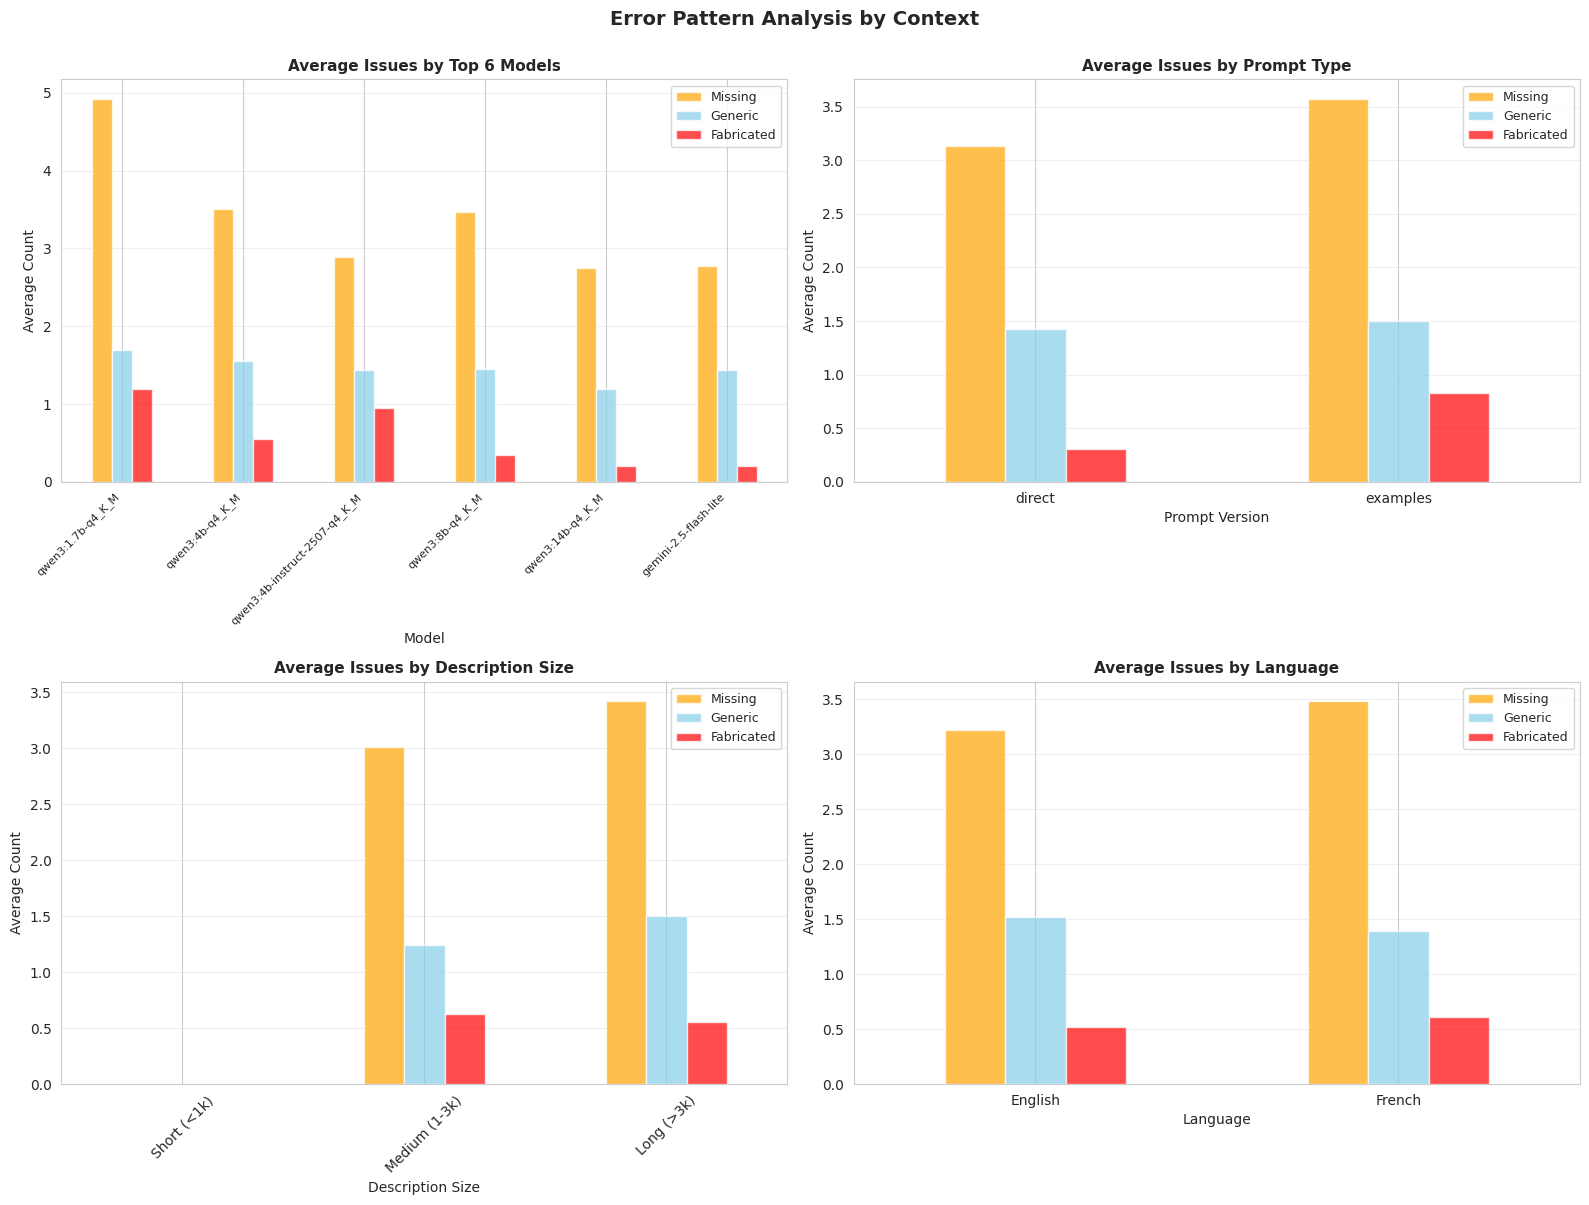

✓ Saved: figs/error_pattern_analysis.png


In [37]:
# Model Comparison: Which models make which types of errors?

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Issue Type Distribution by Top Models
ax = axes[0, 0]
if all(col in results_df.columns for col in ['missing_count', 'generic_count', 'fabricated_count']):
    # Get top 6 models by quality
    top_models = results_df.groupby('extraction_model')['overall_quality'].mean().nlargest(6).index

    issue_by_model = results_df[results_df['extraction_model'].isin(top_models)].groupby('extraction_model')[
        ['missing_count', 'generic_count', 'fabricated_count']
    ].mean()

    issue_by_model.plot(kind='bar', ax=ax,
                       color=['orange', 'skyblue', 'red'], alpha=0.7)
    ax.set_title("Average Issues by Top 6 Models", fontsize=11, fontweight='bold')
    ax.set_xlabel("Model", fontsize=10)
    ax.set_ylabel("Average Count", fontsize=10)
    ax.legend(['Missing', 'Generic', 'Fabricated'], fontsize=9)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

# 2. Error Rate by Prompt Version
ax = axes[0, 1]
if 'prompt_version' in results_df.columns and all(col in results_df.columns for col in ['missing_count', 'generic_count', 'fabricated_count']):
    error_by_prompt = results_df.groupby('prompt_version')[
        ['missing_count', 'generic_count', 'fabricated_count']
    ].mean()

    error_by_prompt.plot(kind='bar', ax=ax,
                        color=['orange', 'skyblue', 'red'], alpha=0.7)
    ax.set_title("Average Issues by Prompt Type", fontsize=11, fontweight='bold')
    ax.set_xlabel("Prompt Version", fontsize=10)
    ax.set_ylabel("Average Count", fontsize=10)
    ax.legend(['Missing', 'Generic', 'Fabricated'], fontsize=9)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)

# 3. Issues by Description Size
ax = axes[1, 0]
if 'size_category' in results_df.columns and all(col in results_df.columns for col in ['missing_count', 'generic_count', 'fabricated_count']):
    error_by_size = results_df.groupby('size_category')[
        ['missing_count', 'generic_count', 'fabricated_count']
    ].mean()

    error_by_size.plot(kind='bar', ax=ax,
                      color=['orange', 'skyblue', 'red'], alpha=0.7)
    ax.set_title("Average Issues by Description Size", fontsize=11, fontweight='bold')
    ax.set_xlabel("Description Size", fontsize=10)
    ax.set_ylabel("Average Count", fontsize=10)
    ax.legend(['Missing', 'Generic', 'Fabricated'], fontsize=9)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

# 4. Issues by Language
ax = axes[1, 1]
if 'description_language' in results_df.columns and all(col in results_df.columns for col in ['missing_count', 'generic_count', 'fabricated_count']):
    error_by_lang = results_df.groupby('description_language')[
        ['missing_count', 'generic_count', 'fabricated_count']
    ].mean()

    error_by_lang.plot(kind='bar', ax=ax,
                      color=['orange', 'skyblue', 'red'], alpha=0.7)
    ax.set_title("Average Issues by Language", fontsize=11, fontweight='bold')
    ax.set_xlabel("Language", fontsize=10)
    ax.set_ylabel("Average Count", fontsize=10)
    ax.legend(['Missing', 'Generic', 'Fabricated'], fontsize=9)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle("Error Pattern Analysis by Context", y=1.00, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("figs/error_pattern_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: figs/error_pattern_analysis.png")

In [38]:
# Case Studies: Best and Worst Extractions

print("="*80)
print(" "*20 + "CASE STUDIES: BEST & WORST EXTRACTIONS")
print("="*80)

# Make sure overall_quality exists
if 'overall_quality' not in results_df.columns:
    results_df['overall_quality'] = results_df[metrics].mean(axis=1)

# Best extraction (highest overall quality)
print("BEST EXTRACTION EXAMPLE")


best_idx = results_df['overall_quality'].idxmax()
best_case = results_df.loc[best_idx]

print(f"\n Scores:")
print(f"  Overall Quality: {best_case['overall_quality']:.2f}/10")
print(f"  Completeness: {best_case['completeness_score']:.2f}/10")
print(f"  Accuracy: {best_case['accuracy_score']:.2f}/10")
print(f"  Specificity: {best_case['specificity_score']:.2f}/10")
print(f"  Hallucination: {best_case['hallucination_score']:.2f}/10")

print(f"\n Model Details:")
print(f"  Extraction Model: {best_case['extraction_model']}")
print(f"  Prompt Version: {best_case['prompt_version']}")
print(f"  Judge Model: {best_case['judge_model']}")
print(f"  Extraction Time: {best_case['extraction_time']:.2f}s")
print(f"  Tokens: {best_case['input_tokens']:.0f} in, {best_case['output_tokens']:.0f} out")

print(f"\n Job Details:")
print(f"  Job ID: {best_case['job_id']}")
print(f"  Title: {best_case['job_title']}")
print(f"  Company: {best_case['job_company']}")
print(f"  Description Length: {best_case['description_length']} chars")
if 'description_language' in best_case:
    print(f"  Language: {best_case['description_language']}")

print(f"\n Judge Feedback:")
if 'missing_count' in best_case:
    print(f"  Missing Items: {best_case['missing_count']}")
    if best_case['missing_count'] > 0 and 'missing_critical_info_parsed' in best_case:
        for item in best_case['missing_critical_info_parsed'][:3]:
            print(f"    - {item}")
if 'generic_count' in best_case:
    print(f"  Generic Items: {best_case['generic_count']}")
    if best_case['generic_count'] > 0 and 'generic_extractions_parsed' in best_case:
        for item in best_case['generic_extractions_parsed'][:3]:
            print(f"    - {item}")
if 'fabricated_count' in best_case:
    print(f"  Fabricated Items: {best_case['fabricated_count']}")
    if best_case['fabricated_count'] > 0 and 'fabricated_info_parsed' in best_case:
        for item in best_case['fabricated_info_parsed'][:3]:
            print(f"    - {item}")

# Worst extraction (lowest overall quality, but still successful)

print("WORST EXTRACTION EXAMPLE")


worst_idx = results_df['overall_quality'].idxmin()
worst_case = results_df.loc[worst_idx]

print(f"\n Scores:")
print(f"  Overall Quality: {worst_case['overall_quality']:.2f}/10")
print(f"  Completeness: {worst_case['completeness_score']:.2f}/10")
print(f"  Accuracy: {worst_case['accuracy_score']:.2f}/10")
print(f"  Specificity: {worst_case['specificity_score']:.2f}/10")
print(f"  Hallucination: {worst_case['hallucination_score']:.2f}/10")

print(f"\n Model Details:")
print(f"  Extraction Model: {worst_case['extraction_model']}")
print(f"  Prompt Version: {worst_case['prompt_version']}")
print(f"  Judge Model: {worst_case['judge_model']}")
print(f"  Extraction Time: {worst_case['extraction_time']:.2f}s")
print(f"  Tokens: {worst_case['input_tokens']:.0f} in, {worst_case['output_tokens']:.0f} out")

print(f"\n Job Details:")
print(f"  Job ID: {worst_case['job_id']}")
print(f"  Title: {worst_case['job_title']}")
print(f"  Company: {worst_case['job_company']}")
print(f"  Description Length: {worst_case['description_length']} chars")
if 'description_language' in worst_case:
    print(f"  Language: {worst_case['description_language']}")

print(f"\n Judge Feedback (Issues Found):")
if 'missing_count' in worst_case:
    print(f"  Missing Items: {worst_case['missing_count']}")
    if worst_case['missing_count'] > 0 and 'missing_critical_info_parsed' in worst_case:
        for item in worst_case['missing_critical_info_parsed'][:5]:
            print(f"    - {item}")
if 'generic_count' in worst_case:
    print(f"  Generic Items: {worst_case['generic_count']}")
    if worst_case['generic_count'] > 0 and 'generic_extractions_parsed' in worst_case:
        for item in worst_case['generic_extractions_parsed'][:5]:
            print(f"    - {item}")
if 'fabricated_count' in worst_case:
    print(f"  Fabricated Items: {worst_case['fabricated_count']}")
    if worst_case['fabricated_count'] > 0 and 'fabricated_info_parsed' in worst_case:
        for item in worst_case['fabricated_info_parsed'][:5]:
            print(f"    - {item}")

print("\n" + "="*80)

                    CASE STUDIES: BEST & WORST EXTRACTIONS
BEST EXTRACTION EXAMPLE

 Scores:
  Overall Quality: 9.75/10
  Completeness: 9.00/10
  Accuracy: 10.00/10
  Specificity: 10.00/10
  Hallucination: 10.00/10

 Model Details:
  Extraction Model: qwen3:1.7b-q4_K_M
  Prompt Version: direct
  Judge Model: gpt-4o
  Extraction Time: 2.71s
  Tokens: 662 in, 321 out

 Job Details:
  Job ID: 5
  Title: Senior Data Scientist, Analytics
  Company: David Energy
  Description Length: 2495 chars
  Language: English

 Judge Feedback:
  Missing Items: 1
    - Clear communication skills
  Generic Items: 0
  Fabricated Items: 0
WORST EXTRACTION EXAMPLE

 Scores:
  Overall Quality: 1.00/10
  Completeness: 2.00/10
  Accuracy: 1.00/10
  Specificity: 1.00/10
  Hallucination: 0.00/10

 Model Details:
  Extraction Model: qwen3:4b-q4_K_M
  Prompt Version: direct
  Judge Model: claude-sonnet-4-5
  Extraction Time: 29.89s
  Tokens: 1487 in, 61 out

 Job Details:
  Job ID: 14
  Title: Principal Machine Lea

# Interactive Extraction Explorer - Judge Validation

In [39]:
def explore_extractions(
    model=None,
    language=None,
    sort_by='overall_quality',
    ascending=False,
    top_n=5,
    show_description=True,
    show_extraction=True,
    show_scores=True,
    show_feedback=True
):
    """
    Interactive extraction explorer for judge validation.

    Parameters:
    -----------
    model : str, optional
        Filter by extraction model (e.g., 'qwen3:14b-q4_K_M', 'gemini-2.5-flash-lite')
    language : str, optional
        Filter by description language (e.g., 'English', 'French')
    sort_by : str, default='overall_quality'
        Sort by column ('overall_quality', 'completeness_score', 'accuracy_score',
        'specificity_score', 'hallucination_score', 'extraction_time')
    ascending : bool, default=False
        Sort order (False = highest first, True = lowest first)
    top_n : int, default=5
        Number of extractions to display
    show_description : bool, default=True
        Show original job description
    show_extraction : bool, default=True
        Show extracted information
    show_scores : bool, default=True
        Show all scores
    show_feedback : bool, default=True
        Show judge feedback (missing, generic, fabricated)
    """

    # Filter data
    filtered_df = results_df.copy()

    if model:
        filtered_df = filtered_df[filtered_df['extraction_model'] == model]

    if language:
        if 'description_language' in filtered_df.columns:
            filtered_df = filtered_df[filtered_df['description_language'] == language]

    # Sort
    if sort_by in filtered_df.columns:
        filtered_df = filtered_df.sort_values(sort_by, ascending=ascending)

    # Limit
    filtered_df = filtered_df.head(top_n)

    if len(filtered_df) == 0:
        print("⚠️ No extractions match your filters!")
        return

    print("="*100)
    print(f"SHOWING {len(filtered_df)} EXTRACTIONS")
    print(f"Filters: Model={model or 'All'}, Language={language or 'All'}")
    print(f"Sorted by: {sort_by} ({'Ascending' if ascending else 'Descending'})")
    print("="*100)

    for idx, (row_idx, row) in enumerate(filtered_df.iterrows(), 1):
        print(f"\n{'='*100}")
        print(f"EXTRACTION #{idx}")
        print(f"{'='*100}")

        # Basic Info
        print(f"\n📋 JOB INFORMATION:")
        print(f"  Job ID: {row['job_id']}")
        print(f"  Title: {row['job_title']}")
        print(f"  Company: {row['job_company']}")
        print(f"  Description Length: {row['description_length']} chars")
        if 'description_language' in row:
            print(f"  Language: {row['description_language']}")

        # Model Info
        print(f"\n🤖 EXTRACTION MODEL:")
        print(f"  Model: {row['extraction_model']}")
        print(f"  Prompt: {row['prompt_version']}")
        print(f"  Time: {row['extraction_time']:.2f}s")
        print(f"  Tokens: {row['input_tokens']:.0f} in, {row['output_tokens']:.0f} out")

        # Scores
        if show_scores:
            print(f"\n📊 SCORES (Judge: {row['judge_model']}):")
            if 'overall_quality' in row:
                print(f"  ⭐ Overall Quality: {row['overall_quality']:.2f}/10")
            print(f"  📝 Completeness:    {row['completeness_score']:.2f}/10")
            print(f"  ✓ Accuracy:         {row['accuracy_score']:.2f}/10")
            print(f"  🎯 Specificity:     {row['specificity_score']:.2f}/10")
            print(f"  🚫 Hallucination:   {row['hallucination_score']:.2f}/10")

        # Original Description
        if show_description:
            print(f"\n📄 ORIGINAL JOB DESCRIPTION:")
            print("-" * 100)
            description = row['job_description']
            # Show first 1000 chars
            if len(description) > 1000:
                print(description[:1000])
                print(f"\n... (truncated, showing 1000/{len(description)} chars)")
            else:
                print(description)
            print("-" * 100)

        # Extracted Information
        if show_extraction and 'extraction' in row:
            print(f"\n🔍 EXTRACTED INFORMATION:")
            print("-" * 100)
            extraction = row['extraction']
            if isinstance(extraction, dict):
                import json
                print(json.dumps(extraction, indent=2, ensure_ascii=False))
            else:
                print(extraction)
            print("-" * 100)

        # Judge Feedback
        if show_feedback:
            print(f"\n💬 JUDGE FEEDBACK:")

            # Missing Info
            if 'missing_count' in row and row['missing_count'] > 0:
                print(f"\n  ⚠️ MISSING CRITICAL INFO ({row['missing_count']} items):")
                if 'missing_critical_info_parsed' in row:
                    for item in row['missing_critical_info_parsed']:
                        print(f"     - {item}")
            else:
                print(f"\n  ✅ No missing critical information")

            # Generic Extractions
            if 'generic_count' in row and row['generic_count'] > 0:
                print(f"\n  🔸 GENERIC EXTRACTIONS ({row['generic_count']} items):")
                if 'generic_extractions_parsed' in row:
                    for item in row['generic_extractions_parsed']:
                        print(f"     - {item}")
            else:
                print(f"\n  ✅ No generic extractions")

            # Fabricated Info
            if 'fabricated_count' in row and row['fabricated_count'] > 0:
                print(f"\n  🚨 FABRICATED INFO ({row['fabricated_count']} items):")
                if 'fabricated_info_parsed' in row:
                    for item in row['fabricated_info_parsed']:
                        print(f"     - {item}")
            else:
                print(f"\n  ✅ No fabricated information")

        print(f"\n{'='*100}\n")

    return filtered_df

# Show available options
print("="*100)
print("EXTRACTION EXPLORER - AVAILABLE OPTIONS")
print("="*100)
print("\n📌 AVAILABLE MODELS:")
for i, model in enumerate(sorted(results_df['extraction_model'].unique()), 1):
    count = len(results_df[results_df['extraction_model'] == model])
    avg_quality = results_df[results_df['extraction_model'] == model]['overall_quality'].mean()
    print(f"  {i}. {model:40s} ({count} extractions, avg quality: {avg_quality:.2f})")

if 'description_language' in results_df.columns:
    print("\n📌 AVAILABLE LANGUAGES:")
    for lang in sorted(results_df['description_language'].unique()):
        count = len(results_df[results_df['description_language'] == lang])
        print(f"  - {lang} ({count} extractions)")

print("\n📌 SORT OPTIONS:")
print("  - overall_quality, completeness_score, accuracy_score")
print("  - specificity_score, hallucination_score, extraction_time")

print("\n" + "="*100)
print("USAGE EXAMPLES:")
print("="*100)
print("""
# Show top 5 extractions overall
explore_extractions(top_n=5)

# Show worst extractions (lowest quality)
explore_extractions(sort_by='overall_quality', ascending=True, top_n=3)

# Show best extractions from a specific model
explore_extractions(model='qwen3:14b-q4_K_M', top_n=5)

# Show French extractions with lowest hallucination scores
explore_extractions(language='French', sort_by='hallucination_score', ascending=True, top_n=3)

# Compare best vs worst completeness
explore_extractions(sort_by='completeness_score', ascending=False, top_n=2)
explore_extractions(sort_by='completeness_score', ascending=True, top_n=2)

# Quick view without descriptions (faster)
explore_extractions(show_description=False, top_n=10)

# Focus on scores and feedback only
explore_extractions(show_description=False, show_extraction=False, top_n=5)
""")

EXTRACTION EXPLORER - AVAILABLE OPTIONS

📌 AVAILABLE MODELS:
  1. gemini-2.5-flash-lite                    (120 extractions, avg quality: 8.97)
  2. qwen3:1.7b-q4_K_M                        (107 extractions, avg quality: 7.79)
  3. qwen3:14b-q4_K_M                         (116 extractions, avg quality: 8.95)
  4. qwen3:4b-instruct-2507-q4_K_M            (120 extractions, avg quality: 8.72)
  5. qwen3:4b-q4_K_M                          (110 extractions, avg quality: 8.45)
  6. qwen3:8b-q4_K_M                          (112 extractions, avg quality: 8.65)

📌 AVAILABLE LANGUAGES:
  - English (342 extractions)
  - French (343 extractions)

📌 SORT OPTIONS:
  - overall_quality, completeness_score, accuracy_score
  - specificity_score, hallucination_score, extraction_time

USAGE EXAMPLES:

# Show top 5 extractions overall
explore_extractions(top_n=5)

# Show worst extractions (lowest quality)
explore_extractions(sort_by='overall_quality', ascending=True, top_n=3)

# Show best extractions from 

In [40]:
explore_extractions(sort_by='overall_quality', ascending=True, top_n=3)

SHOWING 3 EXTRACTIONS
Filters: Model=All, Language=All
Sorted by: overall_quality (Ascending)

EXTRACTION #1

📋 JOB INFORMATION:
  Job ID: 14
  Title: Principal Machine Learning Engineer (Cortex Xpanse)
  Company: Palo Alto Networks
  Description Length: 7144 chars
  Language: English

🤖 EXTRACTION MODEL:
  Model: qwen3:4b-q4_K_M
  Prompt: direct
  Time: 29.89s
  Tokens: 1487 in, 61 out

📊 SCORES (Judge: claude-sonnet-4-5):
  ⭐ Overall Quality: 1.00/10
  📝 Completeness:    2.00/10
  ✓ Accuracy:         1.00/10
  🎯 Specificity:     1.00/10
  🚫 Hallucination:   0.00/10

📄 ORIGINAL JOB DESCRIPTION:
----------------------------------------------------------------------------------------------------
Company Description

Our Mission
At Palo Alto Networks® everything starts and ends with our mission:
Being the cybersecurity partner of choice, protecting our digital way of life.
Our vision is a world where each day is safer and more secure than the one before. We are a company built on the fou

,job_id,job_title,job_company,job_description,description_length,description_language,extraction_model,prompt_version,extraction_time,input_tokens,...,size_category,overall_quality,overall_score,missing_critical_info_parsed,missing_count,generic_extractions_parsed,generic_count,fabricated_info_parsed,fabricated_count,total_issues
148,14,Principal Machine Learning Engineer (Cortex Xp...,Palo Alto Networks,Company Description\n\nOur Mission\nAt Palo Al...,7144,English,qwen3:4b-q4_K_M,direct,29.894096,1487.0,...,Long (>3k),1.0,1.0,[Job title: Principal Machine Learning Enginee...,13,[required_skills are extremely generic ('Analy...,2,[experience_years_min: 3 - The posting does no...,3,18
122,1,Data Engineer,Accenture,Accenture Flex offers you the flexibility of l...,6312,English,qwen3:4b-q4_K_M,direct,192.341770,1380.0,...,Long (>3k),1.5,1.5,[Required skills: SQL and Python (mentioned as...,8,[Remote details: 'Flexible work arrangements' ...,2,[Education required: 'Bachelor's degree or hig...,8,18
236,28,Consultant·e Data Scientist & AI Engineer - Se...,Saegus,"Poursuivant sa croissance, Saegus recherche au...",6642,French,qwen3:4b-q4_K_M,examples,71.370584,2380.0,...,Long (>3k),2.5,2.5,"[Required skills: Python, Bash, RAG systems de...",7,[remote_details field shows 'remote' which is ...,7,[remote_details: 'remote' - the job posting do...,2,16


In [41]:
# Quick comparison functions

def compare_models_on_job(job_id):
    """
    Compare how different models performed on the same job.
    """
    job_extractions = results_df[results_df['job_id'] == job_id].copy()

    if len(job_extractions) == 0:
        print(f"⚠️ Job ID {job_id} not found!")
        return

    # Sort by quality
    job_extractions = job_extractions.sort_values('overall_quality', ascending=False)

    print("="*100)
    print(f"MODEL COMPARISON FOR JOB ID: {job_id}")
    print(f"Job: {job_extractions.iloc[0]['job_title']} at {job_extractions.iloc[0]['job_company']}")
    print("="*100)

    # Summary table
    print(f"\n📊 PERFORMANCE SUMMARY:")
    print("-" * 100)
    print(f"{'Model':<40} {'Quality':>8} {'Complete':>8} {'Accurate':>8} {'Specific':>8} {'Halluc':>8}")
    print("-" * 100)

    for _, row in job_extractions.iterrows():
        print(f"{row['extraction_model']:<40} "
              f"{row['overall_quality']:>8.2f} "
              f"{row['completeness_score']:>8.2f} "
              f"{row['accuracy_score']:>8.2f} "
              f"{row['specificity_score']:>8.2f} "
              f"{row['hallucination_score']:>8.2f}")

    print("-" * 100)

    # Show detailed comparison
    print(f"\n🔍 DETAILED COMPARISON:")
    for idx, (_, row) in enumerate(job_extractions.iterrows(), 1):
        print(f"\n{'-'*100}")
        print(f"#{idx}. {row['extraction_model']} (Quality: {row['overall_quality']:.2f}/10)")
        print(f"{'-'*100}")

        # Issues
        if 'missing_count' in row:
            print(f"  Missing: {row['missing_count']} items")
        if 'generic_count' in row:
            print(f"  Generic: {row['generic_count']} items")
        if 'fabricated_count' in row:
            print(f"  Fabricated: {row['fabricated_count']} items")

        # Show extraction
        if 'extraction' in row and isinstance(row['extraction'], dict):
            import json
            print(f"\n  Extracted Data:")
            for key, value in row['extraction'].items():
                value_str = str(value)[:80]
                print(f"    {key}: {value_str}")

    return job_extractions


def find_disagreements(threshold=3.0):
    """
    Find jobs where different models/judges disagree significantly on quality.
    """
    print("="*100)
    print(f"FINDING EXTRACTIONS WITH JUDGE/MODEL DISAGREEMENT (threshold: {threshold} points)")
    print("="*100)

    disagreements = []

    for job_id in results_df['job_id'].unique():
        job_data = results_df[results_df['job_id'] == job_id]

        if len(job_data) > 1:
            quality_std = job_data['overall_quality'].std()
            quality_range = job_data['overall_quality'].max() - job_data['overall_quality'].min()

            if quality_range >= threshold:
                disagreements.append({
                    'job_id': job_id,
                    'job_title': job_data.iloc[0]['job_title'],
                    'num_extractions': len(job_data),
                    'quality_range': quality_range,
                    'quality_std': quality_std,
                    'max_quality': job_data['overall_quality'].max(),
                    'min_quality': job_data['overall_quality'].min()
                })

    if len(disagreements) == 0:
        print("\n✅ No significant disagreements found!")
        return

    disagreements_df = pd.DataFrame(disagreements).sort_values('quality_range', ascending=False)

    print(f"\n🔍 Found {len(disagreements)} jobs with significant disagreement:\n")
    print(disagreements_df.to_string(index=False))

    print(f"\n💡 Use compare_models_on_job(job_id) to investigate specific cases")

    return disagreements_df


def show_score_distribution(model=None):
    """
    Show score distribution for a specific model or all models.
    """
    import matplotlib.pyplot as plt

    data = results_df if model is None else results_df[results_df['extraction_model'] == model]

    if len(data) == 0:
        print(f"⚠️ No data for model: {model}")
        return

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    score_cols = ['completeness_score', 'accuracy_score', 'specificity_score',
                  'hallucination_score', 'overall_quality']

    for ax, score_col in zip(axes.flat, score_cols):
        if score_col in data.columns:
            ax.hist(data[score_col], bins=20, edgecolor='black', alpha=0.7)
            ax.axvline(data[score_col].mean(), color='red', linestyle='--',
                      linewidth=2, label=f'Mean: {data[score_col].mean():.2f}')
            ax.axvline(data[score_col].median(), color='green', linestyle='--',
                      linewidth=2, label=f'Median: {data[score_col].median():.2f}')
            ax.set_title(score_col.replace('_', ' ').title(), fontweight='bold')
            ax.set_xlabel('Score')
            ax.set_ylabel('Frequency')
            ax.legend()
            ax.grid(alpha=0.3)

    # Issue counts
    ax = axes[1, 2]
    if all(col in data.columns for col in ['missing_count', 'generic_count', 'fabricated_count']):
        issue_means = [
            data['missing_count'].mean(),
            data['generic_count'].mean(),
            data['fabricated_count'].mean()
        ]
        ax.bar(['Missing', 'Generic', 'Fabricated'], issue_means,
               color=['orange', 'skyblue', 'red'], alpha=0.7)
        ax.set_title('Average Issue Counts', fontweight='bold')
        ax.set_ylabel('Average Count')
        ax.grid(axis='y', alpha=0.3)

    title = f"Score Distribution: {model}" if model else "Score Distribution: All Models"
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📊 STATISTICS FOR: {model or 'All Models'}")
    print(f"{'='*60}")
    print(f"Number of extractions: {len(data)}")
    print(f"\nScore Statistics:")
    for col in score_cols:
        if col in data.columns:
            print(f"  {col:25s}: μ={data[col].mean():5.2f}  σ={data[col].std():5.2f}  "
                  f"min={data[col].min():5.2f}  max={data[col].max():5.2f}")

print("\n" + "="*100)
print("ADDITIONAL HELPER FUNCTIONS LOADED:")
print("="*100)
print("""
1. compare_models_on_job(job_id)
   - See how different models extracted the same job
   - Example: compare_models_on_job(0)

2. find_disagreements(threshold=3.0)
   - Find jobs where models/judges disagree significantly
   - Example: find_disagreements(threshold=2.5)

3. show_score_distribution(model=None)
   - Visualize score distributions with histograms
   - Example: show_score_distribution('qwen3:14b-q4_K_M')
   - Example: show_score_distribution()  # All models
""")


ADDITIONAL HELPER FUNCTIONS LOADED:

1. compare_models_on_job(job_id)
   - See how different models extracted the same job
   - Example: compare_models_on_job(0)

2. find_disagreements(threshold=3.0)
   - Find jobs where models/judges disagree significantly
   - Example: find_disagreements(threshold=2.5)

3. show_score_distribution(model=None)
   - Visualize score distributions with histograms
   - Example: show_score_distribution('qwen3:14b-q4_K_M')
   - Example: show_score_distribution()  # All models



In [42]:
compare_models_on_job(0)

MODEL COMPARISON FOR JOB ID: 0
Job: Senior Machine Learning Engineer, Ads R&D at Spotify

📊 PERFORMANCE SUMMARY:
----------------------------------------------------------------------------------------------------
Model                                     Quality Complete Accurate Specific   Halluc
----------------------------------------------------------------------------------------------------
qwen3:1.7b-q4_K_M                            9.50     9.00    10.00     9.00    10.00
qwen3:4b-q4_K_M                              9.50     9.00    10.00     9.00    10.00
qwen3:4b-q4_K_M                              9.50     9.00    10.00     9.00    10.00
gemini-2.5-flash-lite                        9.50     9.00    10.00     9.00    10.00
qwen3:8b-q4_K_M                              9.50     9.00    10.00     9.00    10.00
qwen3:8b-q4_K_M                              9.50     9.00    10.00     9.00    10.00
qwen3:4b-instruct-2507-q4_K_M                9.50     9.00    10.00     9.00    10.

,job_id,job_title,job_company,job_description,description_length,description_language,extraction_model,prompt_version,extraction_time,input_tokens,...,size_category,overall_quality,overall_score,missing_critical_info_parsed,missing_count,generic_extractions_parsed,generic_count,fabricated_info_parsed,fabricated_count,total_issues
60,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:1.7b-q4_K_M,examples,7.459902,1746.0,...,Long (>3k),9.50,9.50,"[Salary range ($176,166.00 - $251,666.00 plus ...",5,[],0,[],0,5
120,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:4b-q4_K_M,direct,6.995207,1261.0,...,Long (>3k),9.50,9.50,[Professional experience in applied machine le...,3,[],0,[],0,3
180,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:4b-q4_K_M,examples,7.543688,1746.0,...,Long (>3k),9.50,9.50,[Professional experience in applied machine le...,3,[],0,[],0,3
720,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,gemini-2.5-flash-lite,direct,1.636506,1650.0,...,Long (>3k),9.50,9.50,"[Salary range ($176,166.00 - $251,666.00)]",1,[],0,[],0,1
360,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:8b-q4_K_M,direct,8.703531,1261.0,...,Long (>3k),9.50,9.50,[Professional experience in applied machine le...,2,[strong technical expertise in software engine...,1,[],0,3
420,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:8b-q4_K_M,examples,21.261635,1746.0,...,Long (>3k),9.50,9.50,"[Salary range ($176,166.00 - $251,666.00, plus...",2,[],0,[],0,2
301,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:4b-instruct-2507-q4_K_M,examples,2.535573,1746.0,...,Long (>3k),9.50,9.50,[Experience years (min and max)],1,"[Team size, Reports to, Education required]",3,[],0,4
240,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:4b-instruct-2507-q4_K_M,direct,4.144101,1261.0,...,Long (>3k),9.50,9.50,"[Salary range: $176,166.00 - $251,666.00 plus ...",3,[],0,[],0,3
780,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,gemini-2.5-flash-lite,examples,2.209988,2059.0,...,Long (>3k),9.50,9.50,"[Salary range ($176,166.00 - $251,666.00) not ...",2,[],0,[],0,2
541,0,"Senior Machine Learning Engineer, Ads R&D",Spotify,Engineering\nMachine Learning\nPermanent\nNew ...,5796,English,qwen3:14b-q4_K_M,examples,10.101323,1746.0,...,Long (>3k),9.50,9.50,[No mention of minimum or maximum years of exp...,4,[],1,[],0,5
